# 1. Data Acquisition

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Set random seed for full reproducibility
np.random.seed(42)

print("Libraries imported and setup complete.")

Libraries imported and setup complete.


# 1-1. Real UCI Air Quality Data

We load the original UCI Air Quality dataset and perform minimal cleaning:
- Combine `Date` and `Time` into a proper `DateTime` column
- Replace the official missing value marker `-200` with `NaN`
- No additional noise or missing values added — preserving authenticity

In [43]:
print("=== Loading and Cleaning Real UCI Air Quality Data ===\n")

# Load the dataset
df_real = pd.read_csv("AirQualityUCI.csv", sep=";", decimal=",")

# Combine Date and Time
df_real['DateTime'] = pd.to_datetime(df_real['Date'] + ' ' + df_real['Time'], 
                                    format='%d/%m/%Y %H.%M.%S')

# Drop original columns
df_real.drop(['Date', 'Time'], axis=1, inplace=True)

# Replace -200 (missing value marker) with NaN
df_real.replace(-200, np.nan, inplace=True)

print("Replaced all -200 values with NaN.")
print(f"Dataset shape: {df_real.shape}")
print("Real data cleaning complete.\n")

=== Loading and Cleaning Real UCI Air Quality Data ===

Replaced all -200 values with NaN.
Dataset shape: (9471, 16)
Real data cleaning complete.



### 1-2. Feature Distributions (After Cleaning)

Visualizing the distribution of all numerical sensor features after replacing -200 with NaN.

KeyboardInterrupt: 

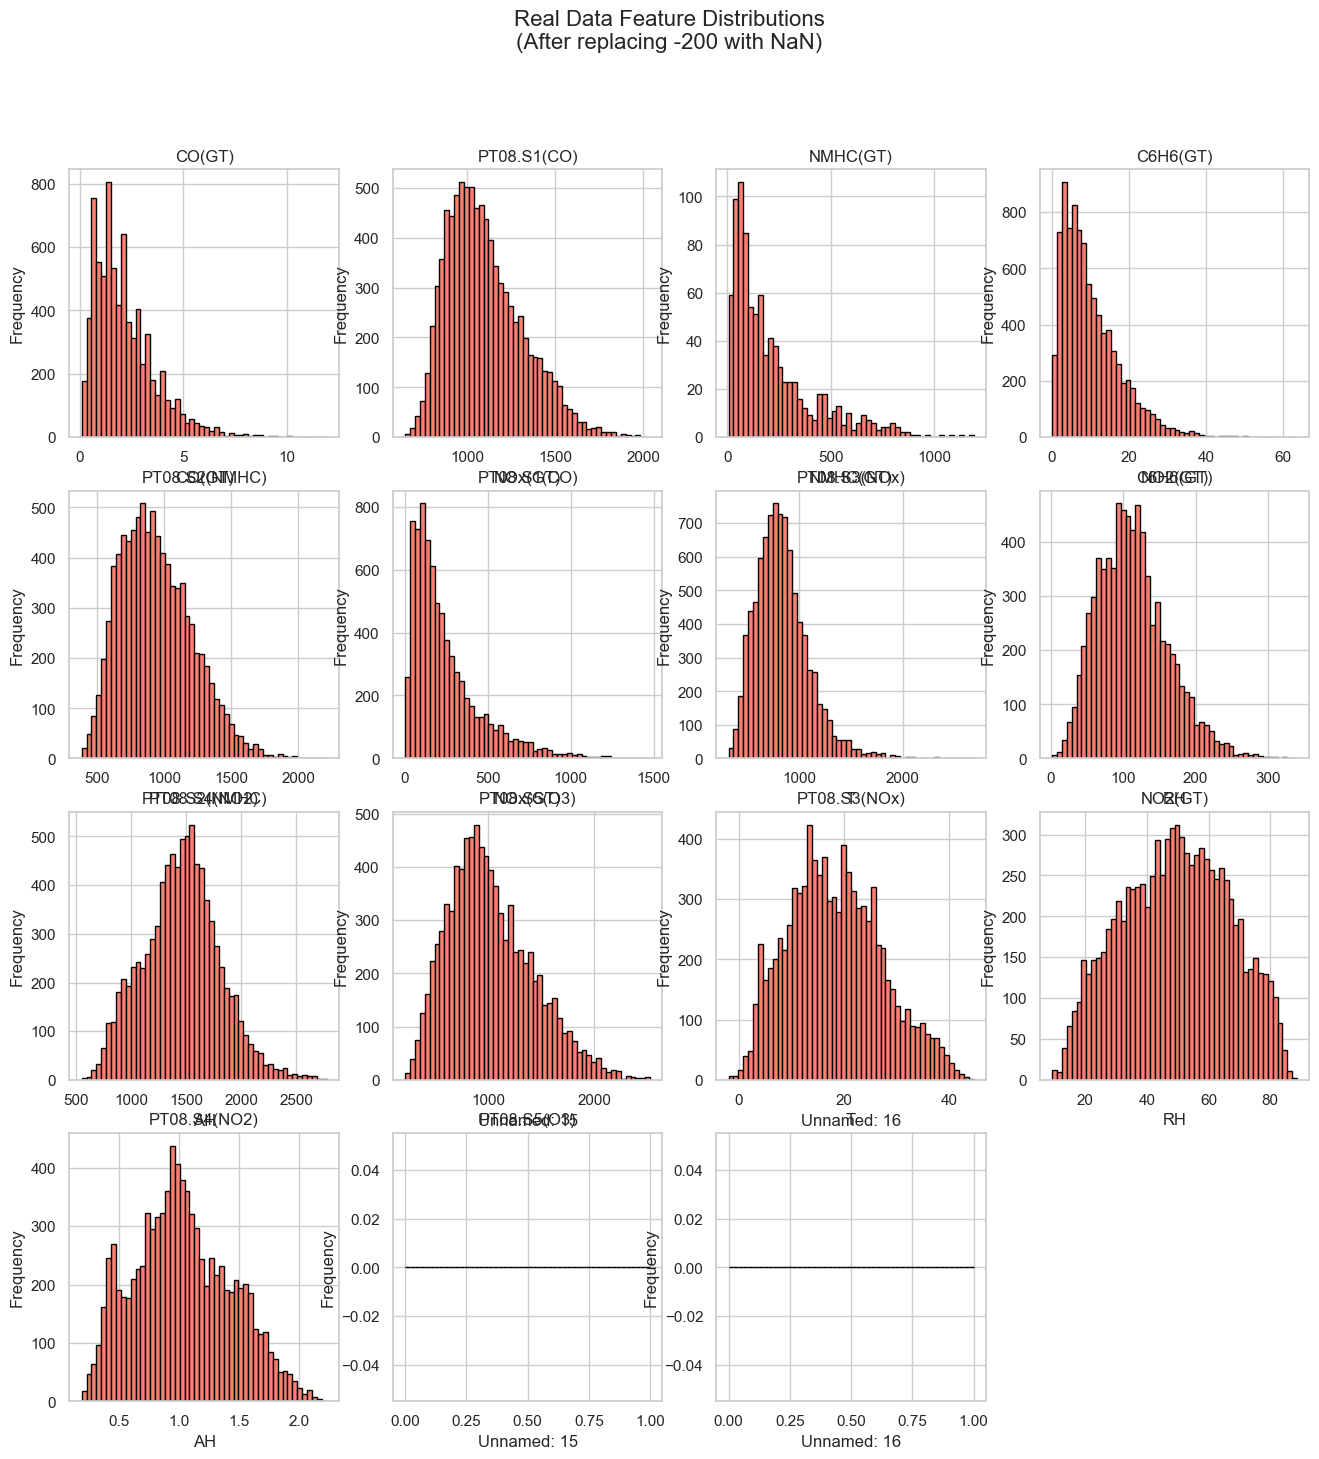

In [44]:
numerical_cols = df_real.select_dtypes(include=np.number).columns

n_cols_plot = 4
n_rows_plot = (len(numerical_cols) + n_cols_plot - 1) // n_cols_plot

plt.figure(figsize=(16, 4 * n_rows_plot))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    df_real[col].dropna().hist(bins=50, color='salmon', edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Real Data Feature Distributions\n(After replacing -200 with NaN)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("real_data_distributions.png", dpi=300)
plt.show()

print("Real data distributions plotted and saved as 'real_data_distributions.png'")

### 1-3. Statistical Summary & Outlier Analysis

Summary statistics including:
- Mean, Variance, Min, Max
- Outlier percentage (IQR method)
- Missing and Valid percentages

In [ ]:
# --- Statistics & Outliers (on cleaned real data) ---
print("=== Statistical Summary (Cleaned Real Data) ===\n")

# Header: Range is now left-aligned with extra space separation
print(f"{'Feature':<15} {'Mean':>10} {'Variance':>12} {'Min':>10} {'Max':>10} {'Outlier %':>12} {'Missing %':>12}     {'Range'}")
print("-" * 120)

for col in numerical_cols:
    data = df_real[col].dropna()
    total_rows = len(df_real)
    missing_pct = (df_real[col].isna().sum() / total_rows) * 100
    
    if len(data) == 0:
        print(f"{col:<15} {'-':>10} {'-':>12} {'-':>10} {'-':>10} {'0.00%':>12} {missing_pct:11.2f}%     {'[- , -]'}")
        continue
    
    mean_val = data.mean()
    var_val = data.var()
    min_val = data.min()
    max_val = data.max()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower) | (data > upper)]
    outlier_pct = (len(outliers) / len(data)) * 100 if len(data) > 0 else 0.0
    
    # Format range string
    range_str = f"[{min_val:.2f}, {max_val:.2f}]"
    
    # Left-align Range with extra spacing before it
    print(f"{col:<15} {mean_val:10.3f} {var_val:12.3f} {min_val:10.3f} {max_val:10.3f} "
          f"{outlier_pct:11.2f}% {missing_pct:11.2f}%     {range_str}")

print("\n(Statistics and outliers calculated only on valid values)")
print("Range shows the observed min-max values of each feature after cleaning.")

=== Statistical Summary (Cleaned Real Data) ===

Feature               Mean     Variance        Min        Max    Outlier %    Missing %     Range
------------------------------------------------------------------------------------------------------------------------
CO(GT)               2.153        2.112      0.100     11.900        2.80%       18.97%     [0.10, 11.90]
PT08.S1(CO)       1099.833    47123.743    647.000   2040.000        1.31%        5.07%     [647.00, 2040.00]
NMHC(GT)           218.812    41803.859      7.000   1189.000        6.02%       90.35%     [7.00, 1189.00]
C6H6(GT)            10.083       55.500      0.100     63.700        2.54%        5.07%     [0.10, 63.70]
PT08.S2(NMHC)      939.153    71199.011    383.000   2214.000        0.72%        5.07%     [383.00, 2214.00]
NOx(GT)            246.897    45360.126      2.000   1479.000        5.64%       18.51%     [2.00, 1479.00]
PT08.S3(NOx)       835.494    65955.136    322.000   2683.000        2.68%        5.

### 1-4. saving the raw data

In [ ]:
df_real.to_csv("real_air_quality_data_raw.csv", index=False)
print("Cleaned real data saved as 'real_air_quality_data_raw.csv'")
print("→ Ready for preprocessing by Person A (next step)\n")

Cleaned real data saved as 'real_air_quality_data_raw.csv'
→ Ready for preprocessing by Person A (next step)



# 2. Synthetic IoT Sensor Data

Generating realistic synthetic sensor readings:
- Temperature and Relative Humidity
- Seasonal patterns (sinusoidal)
- Gaussian sensor noise
- ~5% random missing values to simulate real IoT dropouts

### 2-1 Generating synthetic data

In [ ]:
import numpy as np
import pandas as pd
import hashlib

print("=== Generating Synthetic Sensor Data (Seasonal + Noise, Centered on Real Means) ===\n")

# Global seed (kept for consistency, not relied on for feature RNG)
np.random.seed(42)

# Hourly timestamps
time = pd.date_range("2025-01-01", periods=5000, freq="h")

# Start DataFrame
df_synthetic = pd.DataFrame({"DateTime": time})

numerical_cols = df_real.select_dtypes(include=np.number).columns


def stable_feature_seed(column_name, base_seed=42):
    """
    Generate a fully deterministic seed from a column name.
    Reproducible across runs, machines, and Python versions.
    """
    return base_seed + int(
        hashlib.md5(column_name.encode("utf-8")).hexdigest(),
        16
    ) % 10000


for col in numerical_cols:
    data_real = df_real[col].dropna()
    if len(data_real) == 0:
        df_synthetic[col] = np.nan
        continue

    mean_val = data_real.mean()
    std_val = data_real.std()  # realistic spread

    # Fully reproducible RNG per feature
    feature_seed = stable_feature_seed(col)
    rng = np.random.default_rng(feature_seed)

    # Seasonal pattern: multi-cycle sine wave
    seasonal = np.sin(np.linspace(0, 12 * np.pi, len(time)))  # ~6 cycles

    # Base signal centered on real mean
    values = mean_val + seasonal * std_val * 0.5

    # Gaussian noise (realistic sensor noise)
    noise = rng.normal(0, std_val * 0.3, len(time))
    values += noise

    # Add ~5% missing values (fully reproducible)
    missing_mask = rng.choice([True, False], size=len(time), p=[0.05, 0.95])
    values[missing_mask] = np.nan

    df_synthetic[col] = values


# Save
df_synthetic.to_csv("synthetic_sensor_data_raw.csv", index=False)

print(f"Synthetic data generated: {len(df_synthetic)} rows, matching all {len(numerical_cols)} real features")
print("→ Centered on real mean")
print("→ Seasonal sinusoidal pattern + realistic Gaussian noise (scaled from real std)")
print("→ No clipping → smooth, natural distributions (no end spikes)")
print("→ ~5% missing values per feature")
print("→ 100% reproducible across runs & machines")
print("Saved as 'synthetic_sensor_data_raw.csv'\n")


=== Generating Synthetic Sensor Data (Seasonal + Noise, Centered on Real Means) ===

Synthetic data generated: 5000 rows, matching all 15 real features
→ Centered on real mean
→ Seasonal sinusoidal pattern + realistic Gaussian noise (scaled from real std)
→ No clipping → smooth, natural distributions (no end spikes)
→ ~5% missing values per feature
→ 100% reproducible across runs & machines
Saved as 'synthetic_sensor_data_raw.csv'



### 2-2. Feature Distributions (After adding noise and outliers)


--- Generating Distributions (Synthetic Data) ---



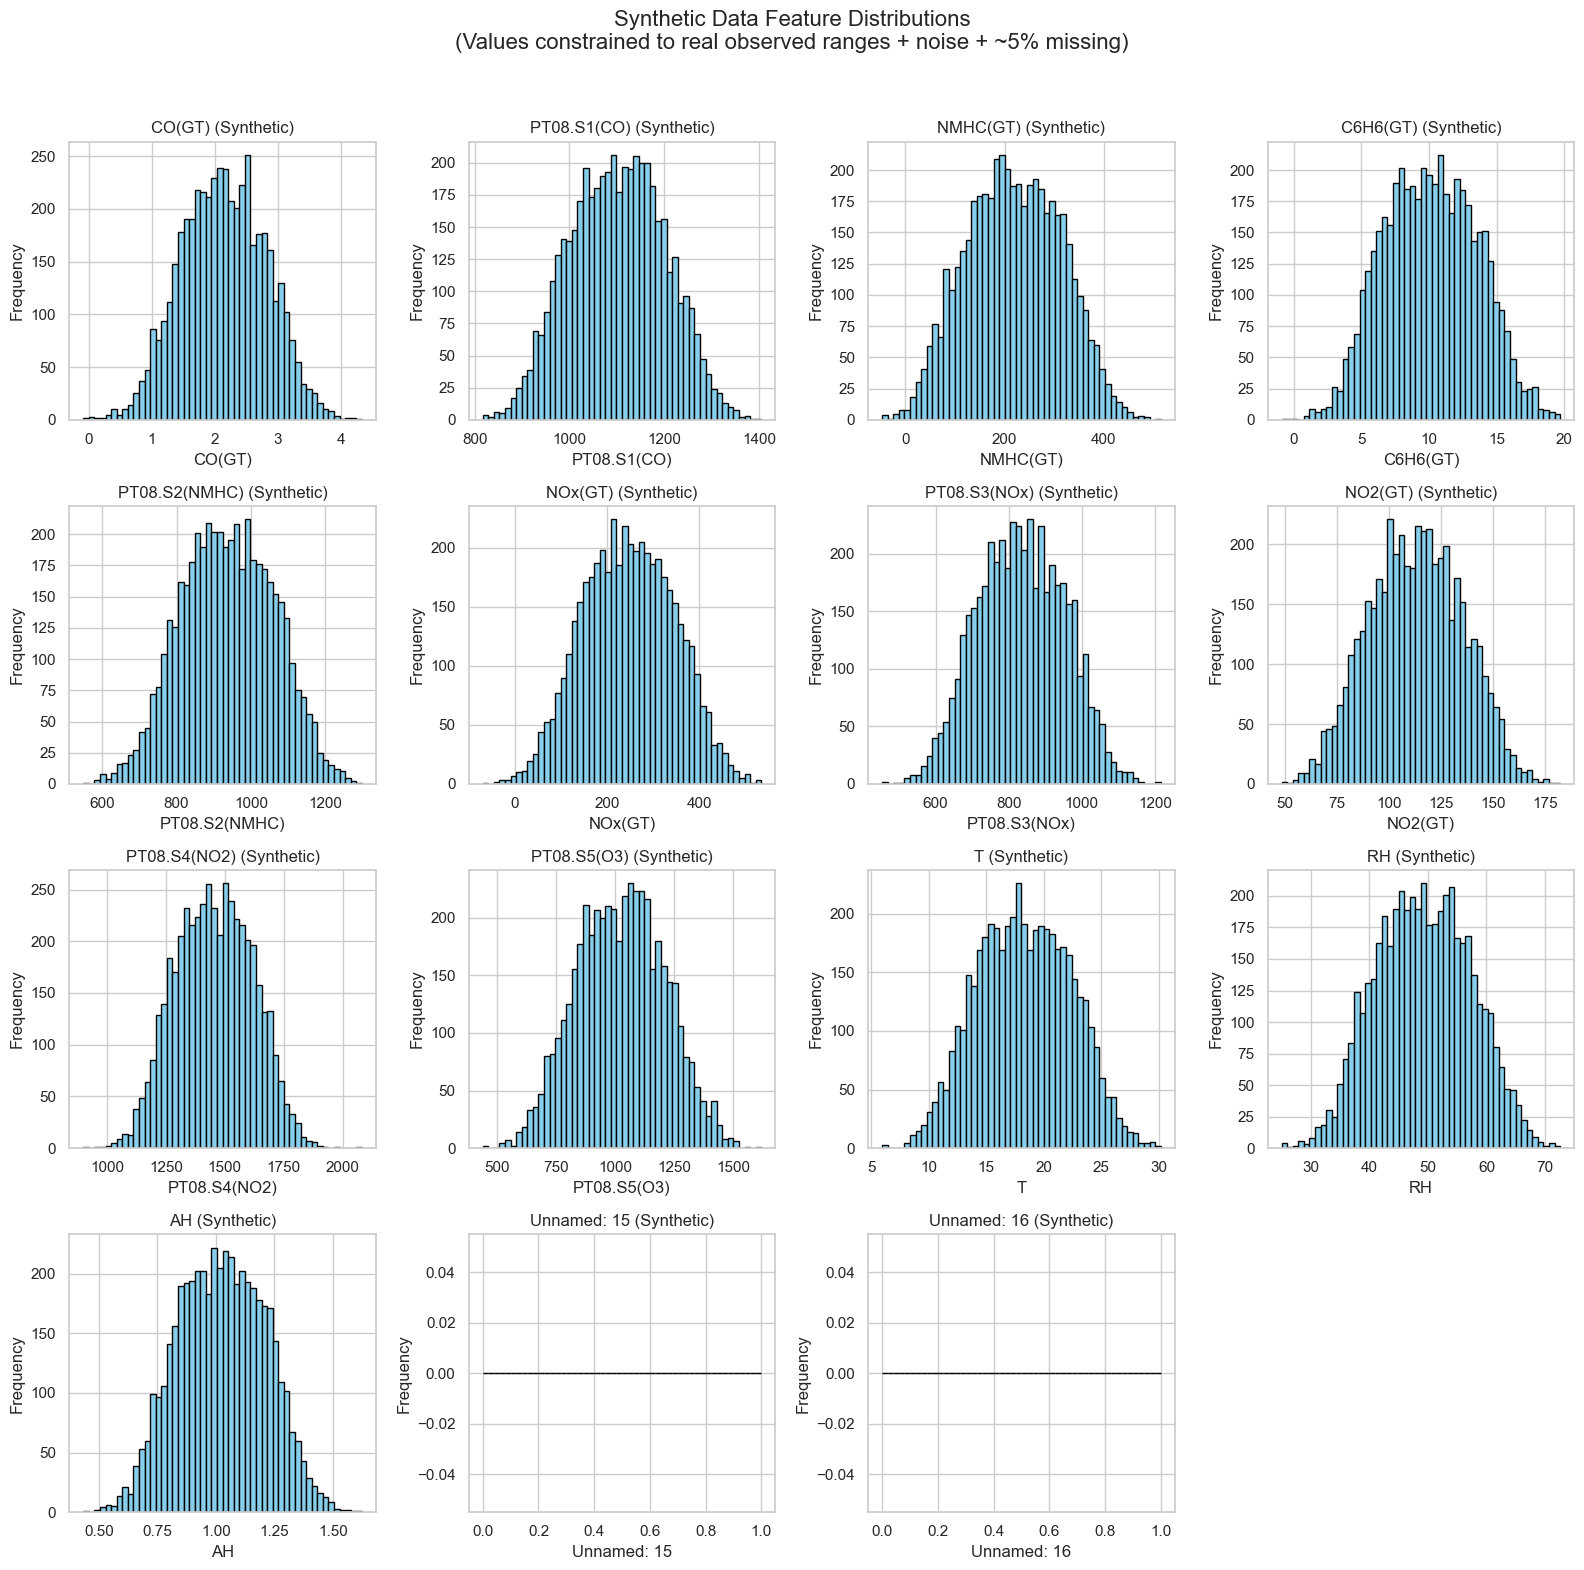

Synthetic distributions saved as 'synthetic_data_distributions.png'



In [ ]:
print("--- Generating Distributions (Synthetic Data) ---\n")

n_cols_plot = 4
n_rows_plot = (len(numerical_cols) + n_cols_plot - 1) // n_cols_plot

plt.figure(figsize=(16, 4 * n_rows_plot))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    df_synthetic[col].dropna().hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f'{col} (Synthetic)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Synthetic Data Feature Distributions\n(Values constrained to real observed ranges + noise + ~5% missing)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("synthetic_data_distributions.png", dpi=300)
plt.show()

print("Synthetic distributions saved as 'synthetic_data_distributions.png'\n")

### 2-3. Statistical Summary & Outlier Analysis


In [ ]:
# --- Statistics & Outliers for Synthetic Data ---
print("=== Statistical Summary (Synthetic Data) ===\n")

# Same header as real data
print(f"{'Feature':<15} {'Mean':>10} {'Variance':>12} {'Min':>10} {'Max':>10} {'Outlier %':>12} {'Missing %':>12}     {'Range'}")
print("-" * 120)

# Use same numerical columns (they match exactly)
for col in numerical_cols:
    data = df_synthetic[col].dropna()
    total_rows = len(df_synthetic)
    missing_pct = (df_synthetic[col].isna().sum() / total_rows) * 100
    
    if len(data) == 0:
        print(f"{col:<15} {'-':>10} {'-':>12} {'-':>10} {'-':>10} {'0.00%':>12} {missing_pct:11.2f}%     {'[- , -]'}")
        continue
    
    mean_val = data.mean()
    var_val = data.var()
    min_val = data.min()
    max_val = data.max()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower) | (data > upper)]
    outlier_pct = (len(outliers) / len(data)) * 100 if len(data) > 0 else 0.0
    
    range_str = f"[{min_val:.2f}, {max_val:.2f}]"
    
    print(f"{col:<15} {mean_val:10.3f} {var_val:12.3f} {min_val:10.3f} {max_val:10.3f} "
          f"{outlier_pct:11.2f}% {missing_pct:11.2f}%     {range_str}")

print("\n(Statistics and outliers calculated only on valid values in synthetic data)")
print("Note: Missing % is approximately 5% due to simulated IoT dropouts.")
print("Mean should be close to real data mean; variance influenced by seasonal pattern + noise.")

=== Statistical Summary (Synthetic Data) ===

Feature               Mean     Variance        Min        Max    Outlier %    Missing %     Range
------------------------------------------------------------------------------------------------------------------------
CO(GT)               2.143        0.443     -0.088      4.339        0.25%        4.86%     [-0.09, 4.34]
PT08.S1(CO)       1101.351     9845.322    817.043   1404.637        0.02%        5.04%     [817.04, 1404.64]
NMHC(GT)           218.851     8916.423    -46.591    514.856        0.02%        4.94%     [-46.59, 514.86]
C6H6(GT)            10.125       11.792     -0.901     19.711        0.04%        5.34%     [-0.90, 19.71]
PT08.S2(NMHC)      937.672    15360.070    549.440   1298.223        0.02%        5.14%     [549.44, 1298.22]
NOx(GT)            247.698     9661.046    -68.921    534.944        0.02%        5.24%     [-68.92, 534.94]
PT08.S3(NOx)       834.324    14024.911    454.120   1216.092        0.08%        5.

# 3. Cleaning & Preprocessing


### 3-1. Load Real Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load real raw data
df_real = pd.read_csv("real_air_quality_data_raw.csv")

# Ensure DateTime is datetime and sorted
df_real['DateTime'] = pd.to_datetime(df_real['DateTime'])
df_real = df_real.sort_values('DateTime').reset_index(drop=True)

print("Real data loaded.")
print(f"Shape: {df_real.shape}")
df_real.head()

Real data loaded.
Shape: (9471, 16)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,DateTime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,2004-03-10 22:00:00


### 3-2. Identify Numerical Columns and drop fully empty columns

In [ ]:
numerical_cols = df_real.select_dtypes(include=np.number).columns
print("Numerical columns:", list(numerical_cols))

empty_cols = df_real.columns[df_real.isna().all()]
if len(empty_cols) > 0:
    print(f"Dropping fully empty columns: {list(empty_cols)}")
    df_real.drop(empty_cols, axis=1, inplace=True)
    numerical_cols = numerical_cols.drop(empty_cols, errors='ignore')

print(f"Shape after drop: {df_real.shape}")

Numerical columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']
Dropping fully empty columns: ['Unnamed: 15', 'Unnamed: 16']
Shape after drop: (9471, 14)


### 3-3. Drop High-Missing Columns

In [ ]:
missing_rates = df_real[numerical_cols].isna().mean()
high_missing = missing_rates[missing_rates > 0.8].index
if len(high_missing) > 0:
    print(f"Dropping columns with >80% missing: {list(high_missing)}")
    df_real.drop(high_missing, axis=1, inplace=True)
    numerical_cols = numerical_cols.drop(high_missing)

print(f"Shape after drop: {df_real.shape}")

Dropping columns with >80% missing: ['NMHC(GT)']
Shape after drop: (9471, 13)


### 3-4. Move Target to End

In [ ]:
target_col = "C6H6(GT)"  # Change if needed
if target_col in df_real.columns:
    target = df_real.pop(target_col)
    df_real[target_col] = target
    print(f"Target '{target_col}' moved to end.")
else:
    print(f"Warning: Target '{target_col}' not found.")
df_real.head()

Target 'C6H6(GT)' moved to end.


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,C6H6(GT)
0,2.6,1360.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,11.9
1,2.0,1292.0,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,9.4
2,2.2,1402.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,9.0
3,2.2,1376.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,9.2
4,1.6,1272.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,6.5


### 3-5. Split Into Train/Test

In [ ]:
split_idx = int(len(df_real) * 0.8)
train_real = df_real.iloc[:split_idx].copy()
test_real = df_real.iloc[split_idx:].copy()

print("Train shape:", train_real.shape)
print("Test shape:", test_real.shape)

Train shape: (7576, 13)
Test shape: (1895, 13)


### 3-6. Impute Missing Values (forward-fill + backward-fill for time-series)

In [ ]:
feature_cols = [col for col in numerical_cols if col != target_col]

# Impute only features in train and test separately
for df, name in [(train_real, "Train"), (test_real, "Test")]:
    print(f"Imputing {name} features with forward-fill + backward-fill.")
    df[feature_cols] = df[feature_cols].ffill().bfill()

    # Check remaining missing in features (should be 0)
    print(f"{name} remaining missing % in features:")
    print(df[feature_cols].isna().mean() * 100)

# Do NOT impute target in test — leave as-is for real prediction
# For train: Drop rows with missing target
train_real = train_real.dropna(subset=[target_col])
print("\nTrain rows after dropping missing target:", len(train_real))

Imputing Train features with forward-fill + backward-fill.
Train remaining missing % in features:
CO(GT)           0.0
PT08.S1(CO)      0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64
Imputing Test features with forward-fill + backward-fill.
Test remaining missing % in features:
CO(GT)           0.0
PT08.S1(CO)      0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64

Train rows after dropping missing target: 7296


### 3-7. Smooth Time-Series

In [ ]:
# Smooth only features in train and test separately
for df, name in [(train_real, "Train"), (test_real, "Test")]:
    print(f"Smoothing {name} features with rolling mean (window=3).")
    for col in feature_cols:
        df[col] = df[col].rolling(window=3, min_periods=1, center=True).mean()

print("Smoothing complete.")
train_real.head()

Smoothing Train features with rolling mean (window=3).
Smoothing Test features with rolling mean (window=3).
Smoothing complete.


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,C6H6(GT)
0,2.300000,1326.000000,1000.500000,134.500000,1115.000000,102.500000,1625.5,1120.000000,13.450000,48.300000,0.741650,2004-03-10 18:00:00,11.9
1,2.266667,1351.333333,980.000000,133.333333,1123.333333,106.333333,1602.0,1104.666667,12.933333,50.200000,0.744500,2004-03-10 19:00:00,9.4
2,2.133333,1356.666667,947.333333,135.333333,1135.333333,109.333333,1566.0,1083.000000,12.066667,53.900000,0.754133,2004-03-10 20:00:00,9.0
3,2.000000,1350.000000,907.666667,144.666667,1145.666667,117.333333,1543.0,1129.000000,11.366667,57.866667,0.775233,2004-03-10 21:00:00,9.2
4,1.666667,1281.666667,844.666667,130.666667,1211.333333,111.333333,1489.0,1087.333333,11.133333,59.600000,0.786767,2004-03-10 22:00:00,6.5


### 3-8. Normalize Features

In [ ]:
# Fit scaler on train features only
scaler = MinMaxScaler()
scaler.fit(train_real[feature_cols])

# Transform both train and test features
train_real[feature_cols] = scaler.transform(train_real[feature_cols])
test_real[feature_cols] = scaler.transform(test_real[feature_cols])

print("Normalization complete (fit on train, applied to both).")
train_real.describe()

Normalization complete (fit on train, applied to both).


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,C6H6(GT)
count,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296.000000,7296,7296.000000
mean,0.181042,0.341668,0.356298,0.157461,0.238374,0.359728,0.445928,0.340447,0.437997,0.511439,0.472852,2004-08-13 23:58:24.769736704,10.612637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004-03-10 18:00:00,0.200000
25%,0.090090,0.224412,0.234688,0.059428,0.162458,0.250630,0.344834,0.220456,0.291765,0.339217,0.339301,2004-05-27 10:45:00,4.900000
50%,0.153153,0.317665,0.343150,0.113720,0.224291,0.343829,0.446381,0.315537,0.430588,0.519897,0.447737,2004-08-13 05:30:00,8.800000
75%,0.243243,0.440485,0.466709,0.202984,0.296613,0.448363,0.547261,0.444249,0.567843,0.680787,0.614957,2004-10-30 21:15:00,14.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2005-01-20 09:00:00,63.700000
std,0.125329,0.156624,0.158233,0.141138,0.112366,0.149581,0.157388,0.164554,0.192832,0.220173,0.193117,NaN,7.583505


### 3-9. Drop Low-Variance Features

In [ ]:
# Calculate variance on train features after scaling
variances = train_real[feature_cols].var()
low_var = variances[variances < 0.01].index
if len(low_var) > 0:
    print(f"Dropping low-variance features: {list(low_var)}")
    train_real.drop(low_var, axis=1, inplace=True)
    test_real.drop(low_var, axis=1, inplace=True)
    feature_cols = [col for col in feature_cols if col not in low_var]

print(f"Train shape after drop: {train_real.shape}")
print(f"Test shape after drop: {test_real.shape}")

Train shape after drop: (7296, 13)
Test shape after drop: (1895, 13)


### 3-10. Save Preprocessed Real Files

In [ ]:
df_real.to_csv("preprocessed_real.csv", index=False)
train_real.to_csv("train_real.csv", index=False)
test_real.to_csv("test_real.csv", index=False)
print("Real data files saved:")
print("- preprocessed_real.csv")
print("- train_real.csv")
print("- test_real.csv")

Real data files saved:
- preprocessed_real.csv
- train_real.csv
- test_real.csv


# 4. Cleaning & Preprocessing for Synthetic Data

### 4-1. Load Synthetic Data

In [ ]:
# Load synthetic raw data
df_synthetic = pd.read_csv("synthetic_sensor_data_raw.csv")

# Ensure DateTime is datetime and sorted
df_synthetic['DateTime'] = pd.to_datetime(df_synthetic['DateTime'])
df_synthetic = df_synthetic.sort_values('DateTime').reset_index(drop=True)

print("Synthetic data loaded.")
print(f"Shape: {df_synthetic.shape}")
df_synthetic.head()

Synthetic data loaded.
Shape: (5000, 16)


,DateTime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2025-01-01 00:00:00,2.419642,1168.583791,84.833075,12.423425,822.514310,260.124442,798.910775,113.524041,1533.025402,1134.589283,15.909349,50.654632,0.721299,NaN,NaN
1,2025-01-01 01:00:00,1.585916,1113.766724,228.948691,14.140313,NaN,218.470591,907.408682,135.149590,1501.239433,1111.170166,16.965712,44.826373,1.081267,NaN,NaN
2,2025-01-01 02:00:00,2.351456,1088.339704,156.019553,NaN,963.592591,261.481283,906.232794,126.275457,1459.544378,1101.878597,24.437854,62.555866,1.129082,NaN,NaN
3,2025-01-01 03:00:00,1.967326,1003.816718,198.230214,10.093573,980.058807,334.616395,752.423324,131.524741,1514.795532,1030.210391,19.260476,47.410135,0.868771,NaN,NaN
4,2025-01-01 04:00:00,2.218400,1160.806518,251.327788,9.661987,1037.291984,269.558108,NaN,140.401774,1665.880404,970.180320,14.696062,49.839811,0.838197,NaN,NaN


### 4-2. Identify Numerical Columns and Drop Fully Empty Columns

In [ ]:
numerical_cols_synth = df_synthetic.select_dtypes(include=np.number).columns
print("Numerical columns (synthetic):", list(numerical_cols_synth))

empty_cols_synth = df_synthetic.columns[df_synthetic.isna().all()]
if len(empty_cols_synth) > 0:
    print(f"Dropping fully empty columns: {list(empty_cols_synth)}")
    df_synthetic.drop(empty_cols_synth, axis=1, inplace=True)
    numerical_cols_synth = numerical_cols_synth.drop(empty_cols_synth, errors='ignore')

print(f"Shape after drop: {df_synthetic.shape}")

Numerical columns (synthetic): ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']
Dropping fully empty columns: ['Unnamed: 15', 'Unnamed: 16']
Shape after drop: (5000, 14)


### 4-3. Drop High-Missing Columns (Synthetic)

In [ ]:
missing_rates_synth = df_synthetic[numerical_cols_synth].isna().mean()
high_missing_synth = missing_rates_synth[missing_rates_synth > 0.8].index
if len(high_missing_synth) > 0:
    print(f"Dropping columns with >80% missing: {list(high_missing_synth)}")
    df_synthetic.drop(high_missing_synth, axis=1, inplace=True)
    numerical_cols_synth = numerical_cols_synth.drop(high_missing_synth)

print(f"Shape after drop: {df_synthetic.shape}")

Shape after drop: (5000, 14)


### 4-4. Move Target to End (Synthetic)

In [ ]:
target_col_synth = "C6H6(GT)"  # Change if needed
if target_col_synth in df_synthetic.columns:
    target_synth = df_synthetic.pop(target_col_synth)
    df_synthetic[target_col_synth] = target_synth
    print(f"Target '{target_col_synth}' moved to end.")
else:
    print(f"Warning: Target '{target_col_synth}' not found.")
df_synthetic.head()

Target 'C6H6(GT)' moved to end.


,DateTime,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
0,2025-01-01 00:00:00,2.419642,1168.583791,84.833075,822.514310,260.124442,798.910775,113.524041,1533.025402,1134.589283,15.909349,50.654632,0.721299,12.423425
1,2025-01-01 01:00:00,1.585916,1113.766724,228.948691,NaN,218.470591,907.408682,135.149590,1501.239433,1111.170166,16.965712,44.826373,1.081267,14.140313
2,2025-01-01 02:00:00,2.351456,1088.339704,156.019553,963.592591,261.481283,906.232794,126.275457,1459.544378,1101.878597,24.437854,62.555866,1.129082,NaN
3,2025-01-01 03:00:00,1.967326,1003.816718,198.230214,980.058807,334.616395,752.423324,131.524741,1514.795532,1030.210391,19.260476,47.410135,0.868771,10.093573
4,2025-01-01 04:00:00,2.218400,1160.806518,251.327788,1037.291984,269.558108,NaN,140.401774,1665.880404,970.180320,14.696062,49.839811,0.838197,9.661987


### 4-5. Split Into Train/Test (Synthetic)

In [ ]:
split_idx_synth = int(len(df_synthetic) * 0.8)
train_synthetic = df_synthetic.iloc[:split_idx_synth].copy()
test_synthetic = df_synthetic.iloc[split_idx_synth:].copy()

print("Train shape:", train_synthetic.shape)
print("Test shape:", test_synthetic.shape)

Train shape: (4000, 14)
Test shape: (1000, 14)


### 4-6. Impute Missing Values (Synthetic)

In [ ]:
feature_cols_synth = [col for col in numerical_cols_synth if col != target_col_synth]

# Impute only features in train and test separately
for df, name in [(train_synthetic, "Train"), (test_synthetic, "Test")]:
    print(f"Imputing {name} features with forward-fill + backward-fill.")
    df[feature_cols_synth] = df[feature_cols_synth].ffill().bfill()

    print(f"{name} remaining missing % in features:")
    print(df[feature_cols_synth].isna().mean() * 100)

# Do NOT impute target in test
# For train: Drop rows with missing target
train_synthetic = train_synthetic.dropna(subset=[target_col_synth])
print("\nTrain rows after dropping missing target:", len(train_synthetic))

Imputing Train features with forward-fill + backward-fill.
Train remaining missing % in features:
CO(GT)           0.0
PT08.S1(CO)      0.0
NMHC(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64
Imputing Test features with forward-fill + backward-fill.
Test remaining missing % in features:
CO(GT)           0.0
PT08.S1(CO)      0.0
NMHC(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64

Train rows after dropping missing target: 3800


### 4-7. Smooth Time-Series (Synthetic)

In [ ]:
# Smooth only features in train and test separately
for df, name in [(train_synthetic, "Train"), (test_synthetic, "Test")]:
    print(f"Smoothing {name} features with rolling mean (window=3).")
    for col in feature_cols_synth:
        df[col] = df[col].rolling(window=3, min_periods=1, center=True).mean()

print("Smoothing complete.")
train_synthetic.head()

Smoothing Train features with rolling mean (window=3).
Smoothing Test features with rolling mean (window=3).
Smoothing complete.


,DateTime,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
0,2025-01-01 00:00:00,2.002779,1141.175258,156.890883,822.514310,239.297516,853.159728,124.336816,1517.132417,1122.879725,16.437530,47.740503,0.901283,12.423425
1,2025-01-01 01:00:00,1.990962,1095.389078,170.670660,875.029142,271.070476,819.580927,126.732791,1516.353456,1091.989947,17.378512,47.630380,0.890446,14.140313
3,2025-01-01 03:00:00,1.923881,1092.796654,226.168897,946.621700,274.215031,804.085110,135.692035,1560.638456,1037.186959,16.974083,47.358773,0.929412,10.093573
4,2025-01-01 04:00:00,2.138430,1092.981227,250.798285,1032.632688,299.089750,750.735310,128.159244,1615.518780,986.502587,18.253931,49.213830,0.892009,9.661987
5,2025-01-01 05:00:00,2.298346,1103.083593,272.107355,1025.649846,297.131503,762.882909,120.018948,1585.390332,943.437573,18.184211,52.197834,0.940583,11.757518


### 4-8. Normalize Features (Synthetic)

In [ ]:
# Fit scaler on train features only
scaler_synth = MinMaxScaler()
scaler_synth.fit(train_synthetic[feature_cols_synth])

# Transform both train and test features
train_synthetic[feature_cols_synth] = scaler_synth.transform(train_synthetic[feature_cols_synth])
test_synthetic[feature_cols_synth] = scaler_synth.transform(test_synthetic[feature_cols_synth])

print("Normalization complete (fit on train, applied to both).")
train_synthetic.describe()

Normalization complete (fit on train, applied to both).


,DateTime,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
count,3800,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,2025-03-24 22:19:25.263157760,0.495991,0.467031,0.538845,0.493214,0.506329,0.529281,0.516426,0.403859,0.529959,0.443954,0.496411,0.534157,10.232879
min,2025-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.901096
25%,2025-02-11 01:45:00,0.342220,0.312139,0.362980,0.344136,0.341309,0.370076,0.362990,0.264228,0.376868,0.287787,0.331615,0.364722,7.627083
50%,2025-03-24 20:30:00,0.501421,0.469517,0.545086,0.499356,0.514234,0.532308,0.518669,0.409706,0.537382,0.449142,0.497414,0.539669,10.233945
75%,2025-05-05 15:15:00,0.645137,0.622788,0.707949,0.640139,0.666675,0.684711,0.670407,0.543211,0.678735,0.598422,0.657879,0.704543,12.815113
max,2025-06-16 15:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.581167
std,NaN,0.186455,0.188313,0.205928,0.180110,0.196590,0.184649,0.182621,0.168824,0.185228,0.184683,0.194176,0.204249,3.449889


### 4-9. Drop Low-Variance Features (Synthetic)

In [ ]:
# Calculate variance on train features after scaling
variances_synth = train_synthetic[feature_cols_synth].var()
low_var_synth = variances_synth[variances_synth < 0.01].index
if len(low_var_synth) > 0:
    print(f"Dropping low-variance features: {list(low_var_synth)}")
    train_synthetic.drop(low_var_synth, axis=1, inplace=True)
    test_synthetic.drop(low_var_synth, axis=1, inplace=True)
    feature_cols_synth = [col for col in feature_cols_synth if col not in low_var_synth]

print(f"Train shape after drop: {train_synthetic.shape}")
print(f"Test shape after drop: {test_synthetic.shape}")

Train shape after drop: (3800, 14)
Test shape after drop: (1000, 14)


### 4-10. Save Preprocessed Synthetic Files

In [ ]:
df_synthetic.to_csv("preprocessed_synthetic.csv", index=False)
train_synthetic.to_csv("train_synthetic.csv", index=False)
test_synthetic.to_csv("test_synthetic.csv", index=False)
print("Synthetic data files saved:")
print("- preprocessed_synthetic.csv")
print("- train_synthetic.csv")
print("- test_synthetic.csv")

Synthetic data files saved:
- preprocessed_synthetic.csv
- train_synthetic.csv
- test_synthetic.csv


# 5. Model Training

### 5-1. Directory structure setup

In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             roc_curve, auc, precision_recall_curve, confusion_matrix,
                             average_precision_score)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


print("SECTION 5.1: CREATING DIRECTORY STRUCTURE")
directories = {
    'models': 'models/onnx',
    'visualizations': 'visualizations',
    'results': 'results',
    'predictions': 'predictions'
}
for name, path in directories.items():
    os.makedirs(path, exist_ok=True)
    print(f"Created/verified: {path}/")
print(f"\nDirectory structure ready!\n")

SECTION 5.1: CREATING DIRECTORY STRUCTURE
Created/verified: models/onnx/
Created/verified: visualizations/
Created/verified: results/
Created/verified: predictions/

Directory structure ready!



### 5-2. Data Loading

In [42]:
print("SECTION 5.2: LOADING PREPROCESSED DATA")
train_real = pd.read_csv("train_real.csv")
test_real = pd.read_csv("test_real.csv")
train_synthetic = pd.read_csv("train_synthetic.csv")
test_synthetic = pd.read_csv("test_synthetic.csv")
target_col = "C6H6(GT)"
print(f"Real Train: {train_real.shape}, Real Test: {test_real.shape}")
print(f"Synthetic Train: {train_synthetic.shape}, Synthetic Test: {test_synthetic.shape}\n")

SECTION 5.2: LOADING PREPROCESSED DATA
Real Train: (7296, 13), Real Test: (1895, 13)
Synthetic Train: (3800, 14), Synthetic Test: (1000, 14)



### 5-3. Data Preparation

In [43]:
print("SECTION 5.3: PREPARING FEATURES AND TARGET")
def prepare_data(train_df, test_df, target_col):
    feature_cols = [col for col in train_df.columns
                   if col not in ['DateTime', target_col]]
   
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values
   
    test_valid = test_df.dropna(subset=[target_col])
    X_test = test_valid[feature_cols].values
    y_test = test_valid[target_col].values
   
    return X_train, y_train, X_test, y_test, feature_cols

X_train_real, y_train_real, X_test_real, y_test_real, features_real = \
    prepare_data(train_real, test_real, target_col)
X_train_synth, y_train_synth, X_test_synth, y_test_synth, features_synth = \
    prepare_data(train_synthetic, test_synthetic, target_col)

print(f"Real Dataset: Train {X_train_real.shape}, Test {X_test_real.shape}")
print(f"Synthetic Dataset: Train {X_train_synth.shape}, Test {X_test_synth.shape}\n")

# Binarization for classification-style plots (ROC, Confusion Matrix, Precision-Recall)
threshold_real = np.median(y_train_real)
threshold_synth = np.median(y_train_synth)
y_test_bin_real = (y_test_real >= threshold_real).astype(int)
y_test_bin_synth = (y_test_synth >= threshold_synth).astype(int)
print("Binarized test targets created for classification-style evaluation\n")

SECTION 5.3: PREPARING FEATURES AND TARGET
Real Dataset: Train (7296, 11), Test (1695, 11)
Synthetic Dataset: Train (3800, 12), Test (933, 12)

Binarized test targets created for classification-style evaluation



### 5-4. Model Definition

In [44]:
print("SECTION 5.4: DEFINING REGRESSION MODELS")
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Support Vector": SVR(kernel='rbf', C=100, gamma='scale')
}
print(f"Models configured: {list(models.keys())}\n")

SECTION 5.4: DEFINING REGRESSION MODELS
Models configured: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector']



### 5-5. Model Training & Saving To ONNX

In [45]:
print("SECTION 5.5: MODEL TRAINING & SAVING TO ONNX")

onnx_files = {}
cv_results = {} 

for dataset_name, X_train, y_train, features in [
    ("real", X_train_real, y_train_real, features_real),
    ("synthetic", X_train_synth, y_train_synth, features_synth)
]:
    print(f"\n--- Training models on {dataset_name.upper()} data ---")
    
    for model_name, model_template in models.items():
        print(f"\nTraining {model_name}...")
        model = clone(model_template)
        model.fit(X_train, y_train)
        
        # Cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
        cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
        print(f"  CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
        print(f"  CV R²:   {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
        
        cv_results[(model_name, dataset_name)] = (cv_rmse, cv_r2)
        
        # ONNX Export
        safe_name = model_name.replace(" ", "_").replace("/", "_")
        onnx_path = f"models/onnx/{safe_name}_{dataset_name}.onnx"
        initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
        
        try:
            onnx_model = convert_sklearn(model, initial_types=initial_type)
            with open(onnx_path, "wb") as f:
                f.write(onnx_model.SerializeToString())
            print(f"Exported ONNX: {onnx_path}")
            onnx_files[(model_name, dataset_name)] = onnx_path
        except Exception as e:
            print(f"Export failed: {e}")

print(f"TRAINING & ONNX EXPORT COMPLETE — {len(onnx_files)} models saved")

SECTION 5.5: MODEL TRAINING & SAVING TO ONNX

--- Training models on REAL data ---

Training Linear Regression...
  CV RMSE: 2.1157 ± 0.0977
  CV R²:   0.9219 ± 0.0041
Exported ONNX: models/onnx/Linear_Regression_real.onnx

Training Ridge Regression...
  CV RMSE: 2.1246 ± 0.1132
  CV R²:   0.9213 ± 0.0050
Exported ONNX: models/onnx/Ridge_Regression_real.onnx

Training Lasso Regression...
  CV RMSE: 2.3651 ± 0.1400
  CV R²:   0.9026 ± 0.0049
Exported ONNX: models/onnx/Lasso_Regression_real.onnx

Training Random Forest...
  CV RMSE: 1.7599 ± 0.0475
  CV R²:   0.9459 ± 0.0023
Exported ONNX: models/onnx/Random_Forest_real.onnx

Training Gradient Boosting...
  CV RMSE: 1.7853 ± 0.0621
  CV R²:   0.9444 ± 0.0013
Exported ONNX: models/onnx/Gradient_Boosting_real.onnx

Training Support Vector...
  CV RMSE: 1.8598 ± 0.0841
  CV R²:   0.9396 ± 0.0033
Exported ONNX: models/onnx/Support_Vector_real.onnx

--- Training models on SYNTHETIC data ---

Training Linear Regression...
  CV RMSE: 2.2737 ± 0

### 5-6. Load ONNX Models & Predict

In [46]:
print("SECTION 5.6: LOAD ONNX MODELS & PRODUCE PREDICTIONS")

onnx_predictions_real = {}
onnx_predictions_synth = {}
results_real = []
results_synth = []

for (model_name, dataset_name), onnx_path in onnx_files.items():
    try:
        print(f"\nLoading: {onnx_path}")
        session = ort.InferenceSession(onnx_path)
        input_name = session.get_inputs()[0].name
        
        # Select correct test set
        X_test = X_test_real if dataset_name == "real" else X_test_synth
        y_test = y_test_real if dataset_name == "real" else y_test_synth
        y_test_bin = y_test_bin_real if dataset_name == "real" else y_test_bin_synth
        
        X_test_f32 = X_test.astype(np.float32)
        output = session.run(None, {input_name: X_test_f32})
        y_pred_onnx = np.array(output[0]).flatten()
        
        print(f"Predictions generated ({len(y_pred_onnx)} samples)")
        
        # Store predictions
        if dataset_name == "real":
            onnx_predictions_real[model_name] = y_pred_onnx
        else:
            onnx_predictions_synth[model_name] = y_pred_onnx
        
        # Compute metrics for later use
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_onnx))
        test_mae = mean_absolute_error(y_test, y_pred_onnx)
        test_r2 = r2_score(y_test, y_pred_onnx)
        
        # Get CV from earlier
        cv_rmse_scores, cv_r2_scores = cv_results.get((model_name, dataset_name), (None, None))
        cv_rmse_mean = cv_rmse_scores.mean() if cv_rmse_scores is not None else None
        cv_r2_mean = cv_r2_scores.mean() if cv_r2_scores is not None else None
        
        result = {
            'model_name': model_name,
            'dataset': dataset_name,
            'y_test': y_test,
            'y_test_bin': y_test_bin,
            'y_pred_onnx': y_pred_onnx,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'cv_rmse_mean': cv_rmse_mean,
            'cv_rmse_scores': cv_rmse_scores,
            'cv_r2_scores': cv_r2_scores,
            'onnx_file': onnx_path
        }
        
        if dataset_name == "real":
            results_real.append(result)
        else:
            results_synth.append(result)
            
    except Exception as e:
        print(f"Failed to load/run {onnx_path}: {e}")

# Save predictions
os.makedirs("predictions", exist_ok=True)
if onnx_predictions_real:
    pd.DataFrame(onnx_predictions_real, index=range(len(y_test_real))) \
      .assign(Actual=y_test_real).to_csv("predictions/onnx_predictions_real.csv", index=False)
    print("Real ONNX predictions saved")
if onnx_predictions_synth:
    pd.DataFrame(onnx_predictions_synth, index=range(len(y_test_synth))) \
      .assign(Actual=y_test_synth).to_csv("predictions/onnx_predictions_synthetic.csv", index=False)
    print("Synthetic ONNX predictions saved")

print("ONNX LOADING & PREDICTION COMPLETE")


SECTION 5.6: LOAD ONNX MODELS & PRODUCE PREDICTIONS

Loading: models/onnx/Linear_Regression_real.onnx
Predictions generated (1695 samples)

Loading: models/onnx/Ridge_Regression_real.onnx
Predictions generated (1695 samples)

Loading: models/onnx/Lasso_Regression_real.onnx
Predictions generated (1695 samples)

Loading: models/onnx/Random_Forest_real.onnx
Predictions generated (1695 samples)

Loading: models/onnx/Gradient_Boosting_real.onnx
Predictions generated (1695 samples)

Loading: models/onnx/Support_Vector_real.onnx
Predictions generated (1695 samples)

Loading: models/onnx/Linear_Regression_synthetic.onnx
Predictions generated (933 samples)

Loading: models/onnx/Ridge_Regression_synthetic.onnx
Predictions generated (933 samples)

Loading: models/onnx/Lasso_Regression_synthetic.onnx
Predictions generated (933 samples)

Loading: models/onnx/Random_Forest_synthetic.onnx
Predictions generated (933 samples)

Loading: models/onnx/Gradient_Boosting_synthetic.onnx
Predictions generated 

### 5-7. Save ONNX Predictions To CSV

In [47]:
print("SAVING ONNX PREDICTIONS")
os.makedirs("predictions", exist_ok=True)

# Real data
if results_real:
    onnx_pred_real = {r['model_name']: r['y_pred_onnx'] for r in results_real}
    df_onnx_real = pd.DataFrame(onnx_pred_real)
    df_onnx_real['Actual'] = y_test_real
    df_onnx_real.to_csv("predictions/onnx_predictions_real.csv", index=False)
    print("Real ONNX predictions saved")
else:
    print(" No successful ONNX predictions for real data")

# Synthetic data
if results_synth:
    onnx_pred_synth = {r['model_name']: r['y_pred_onnx'] for r in results_synth}
    df_onnx_synth = pd.DataFrame(onnx_pred_synth)
    df_onnx_synth['Actual'] = y_test_synth
    df_onnx_synth.to_csv("predictions/onnx_predictions_synthetic.csv", index=False)
    print("Synthetic ONNX predictions saved")
else:
    print("No successful ONNX predictions for synthetic data")

SAVING ONNX PREDICTIONS
Real ONNX predictions saved
Synthetic ONNX predictions saved


# 6. Visualizaion & Evaluation

### 6-1. Metrics Comparison

SECTION 6.1: VISUALIZATION - METRICS COMPARISON


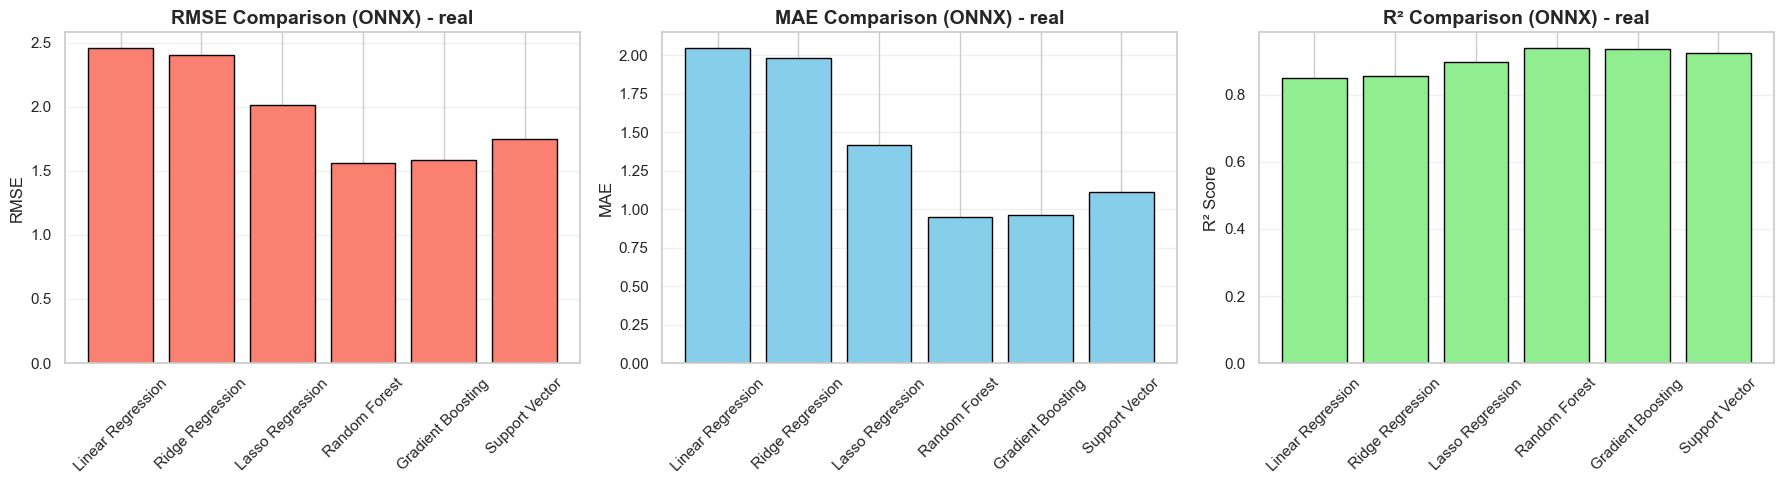

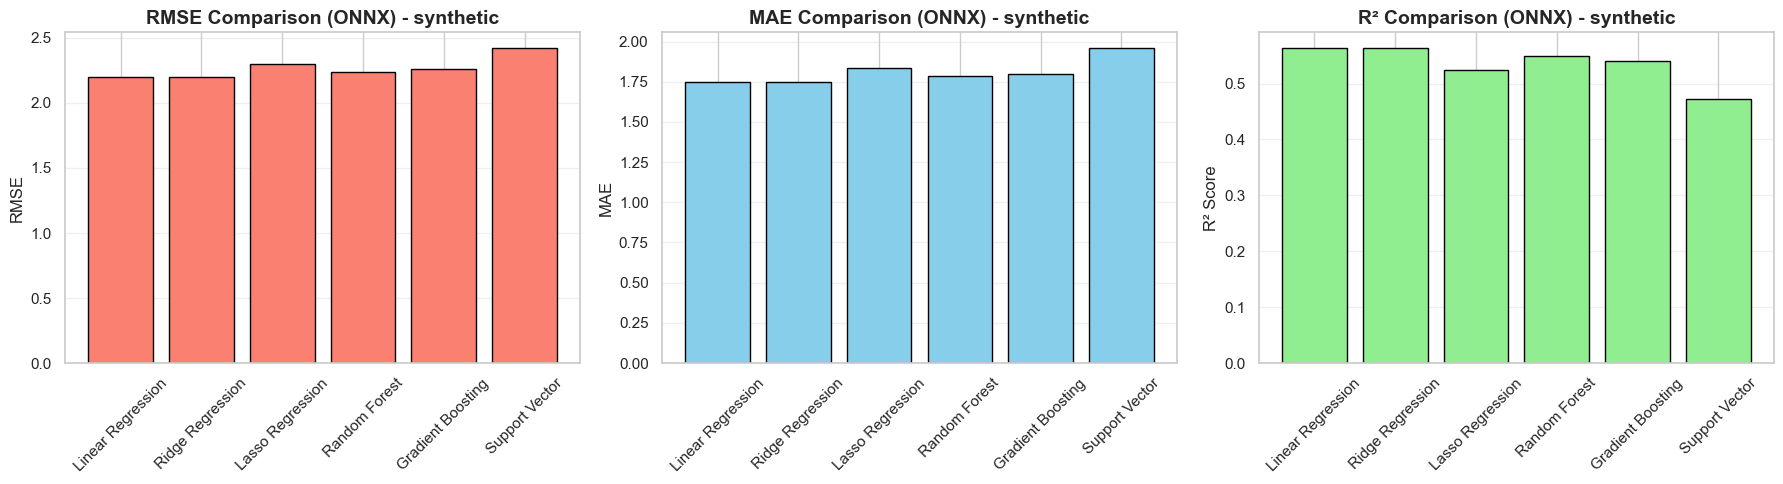

 ONNX metrics comparison charts saved


In [48]:
print("SECTION 6.1: VISUALIZATION - METRICS COMPARISON")

def plot_metrics_comparison(results, dataset_name):
    models_list = [r['model_name'] for r in results]
    rmse_vals = [r['test_rmse'] for r in results]
    mae_vals = [r['test_mae'] for r in results]
    r2_vals = [r['test_r2'] for r in results]
   
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
   
    axes[0].bar(models_list, rmse_vals, color='salmon', edgecolor='black')
    axes[0].set_title(f'RMSE Comparison (ONNX) - {dataset_name}', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('RMSE', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
   
    axes[1].bar(models_list, mae_vals, color='skyblue', edgecolor='black')
    axes[1].set_title(f'MAE Comparison (ONNX) - {dataset_name}', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
   
    axes[2].bar(models_list, r2_vals, color='lightgreen', edgecolor='black')
    axes[2].set_title(f'R² Comparison (ONNX) - {dataset_name}', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('R² Score', fontsize=12)
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', alpha=0.3)
   
    plt.tight_layout()
    plt.savefig(f"visualizations/metrics_comparison_onnx_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_metrics_comparison(results_real, "real")
if results_synth:
    plot_metrics_comparison(results_synth, "synthetic")
print(" ONNX metrics comparison charts saved")

### 6-2. Predictions VS Actual

SECTION 6.2: VISUALIZATION - PREDICTIONS VS ACTUAL


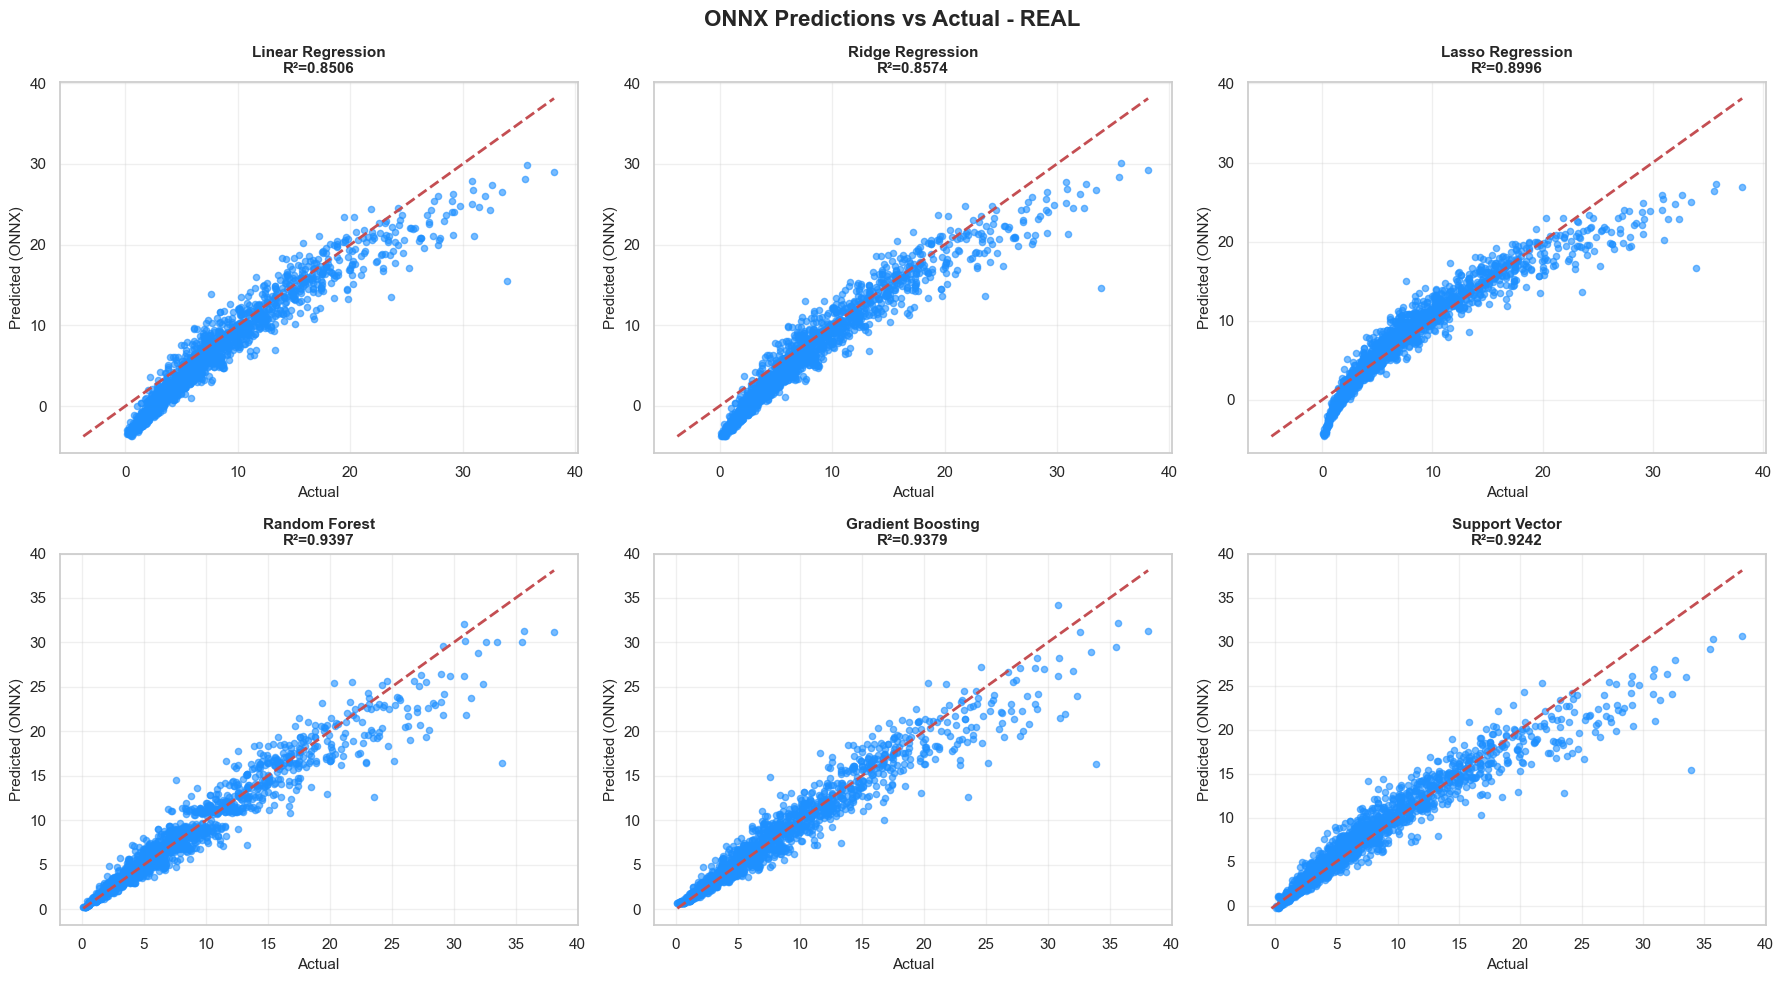

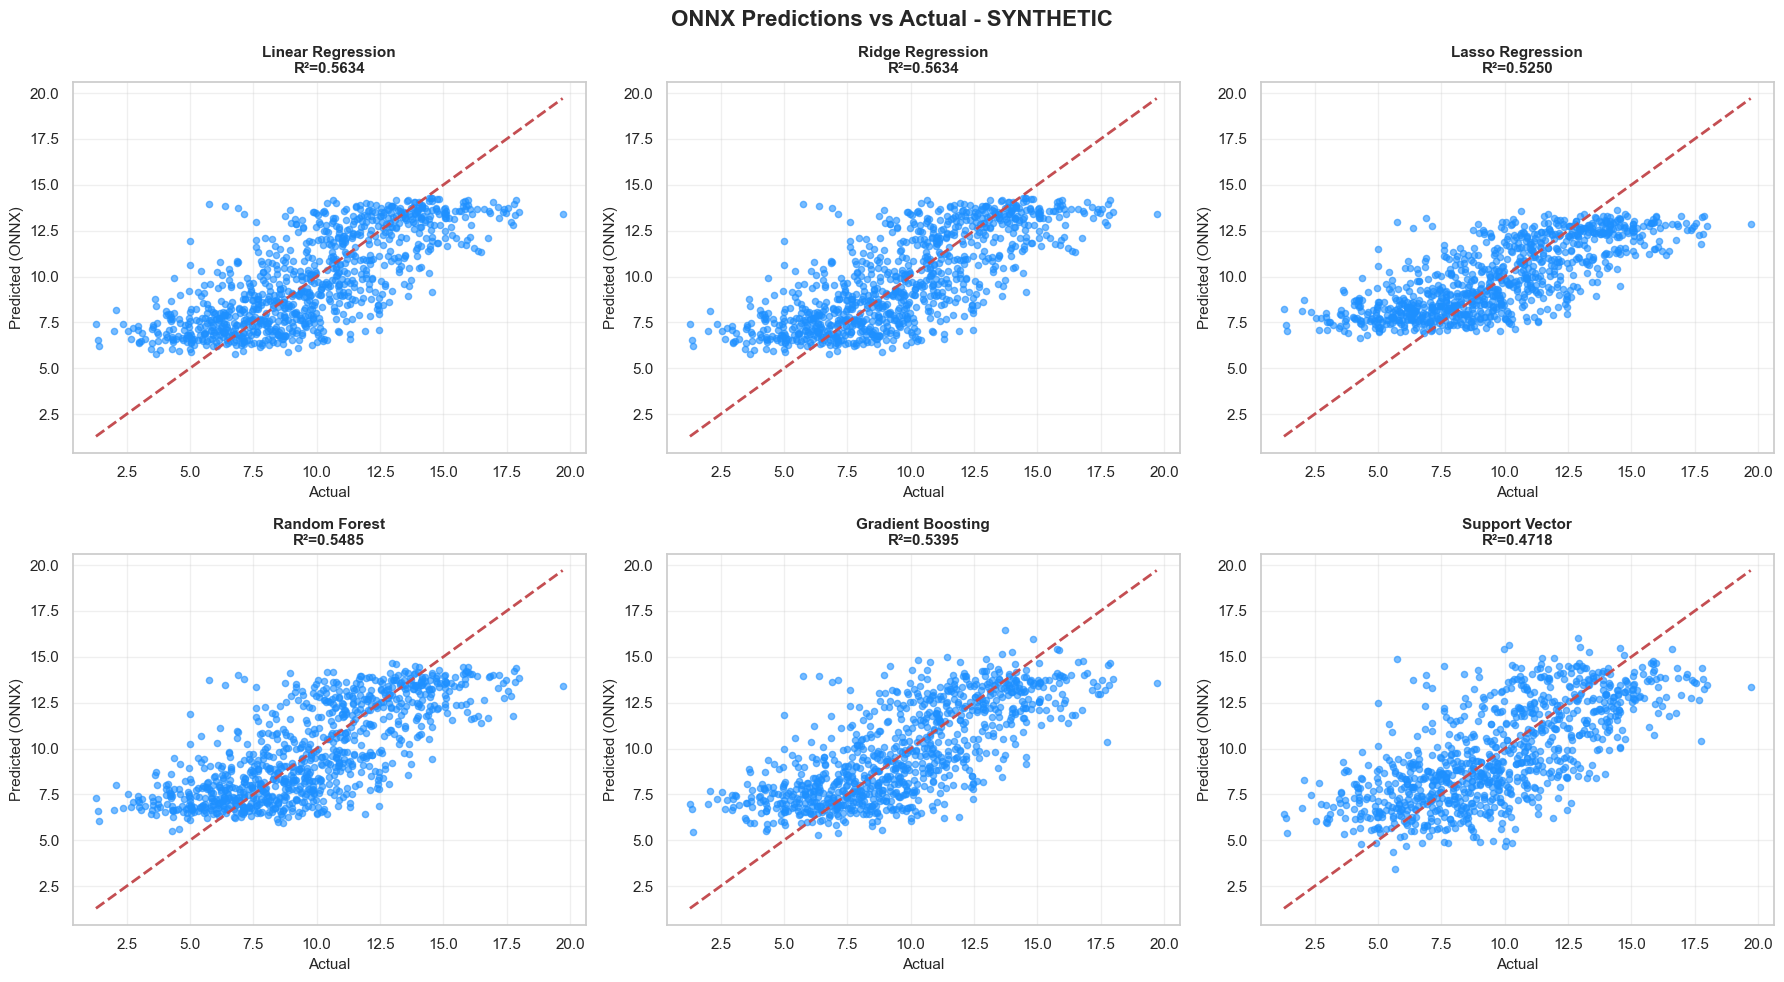

 ONNX predictions vs actual plots saved


In [49]:
print("SECTION 6.2: VISUALIZATION - PREDICTIONS VS ACTUAL")
def plot_predictions_vs_actual(results, dataset_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
   
    for i, r in enumerate(results):
        ax = axes[i]
        # USE ONNX PREDICTIONS FOR PLOTTING
        ax.scatter(r['y_test'], r['y_pred_onnx'], alpha=0.6, s=20, color='dodgerblue')
       
        min_val = min(r['y_test'].min(), r['y_pred_onnx'].min())
        max_val = max(r['y_test'].max(), r['y_pred_onnx'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
       
        ax.set_xlabel('Actual', fontsize=11)
        ax.set_ylabel('Predicted (ONNX)', fontsize=11)
        ax.set_title(f"{r['model_name']}\nR²={r['test_r2']:.4f}", fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
   
    plt.suptitle(f'ONNX Predictions vs Actual - {dataset_name.upper()}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"visualizations/onnx_predictions_vs_actual_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_predictions_vs_actual(results_real, "real")
if results_synth:
    plot_predictions_vs_actual(results_synth, "synthetic")
print(" ONNX predictions vs actual plots saved")

### 6-3. Residuals Analysis

SECTION 6.3: VISUALIZATION - RESIDUALS ANALYSIS


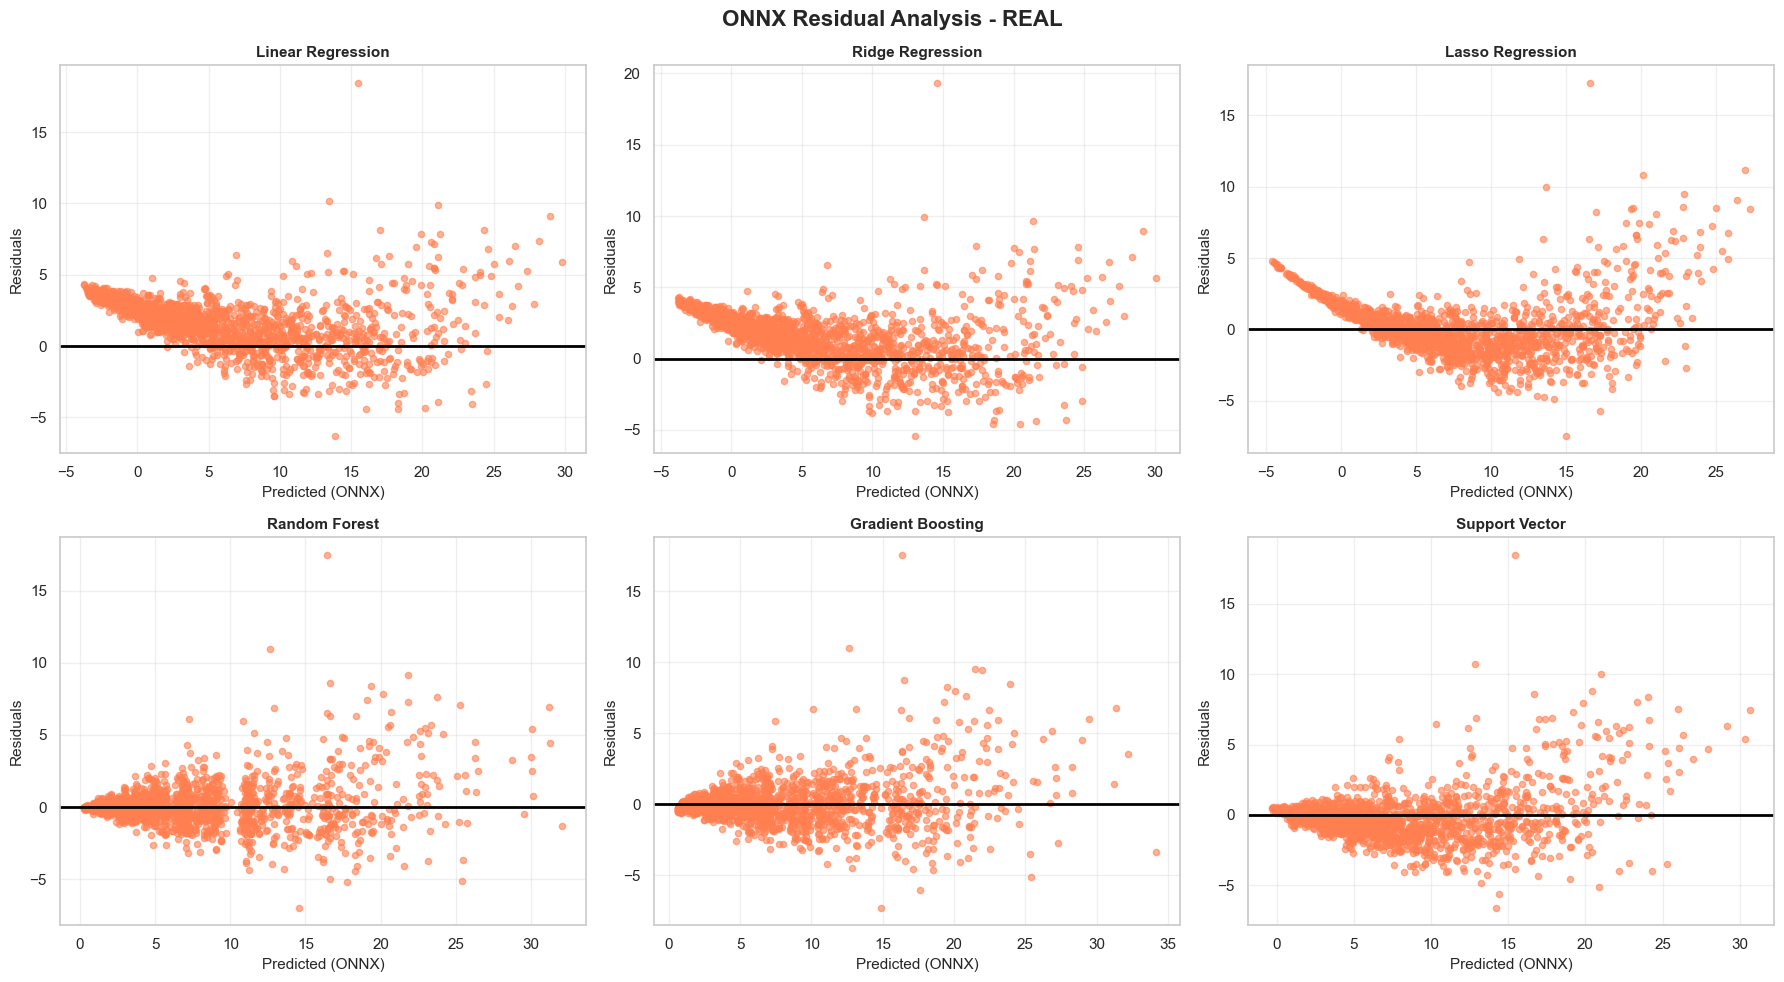

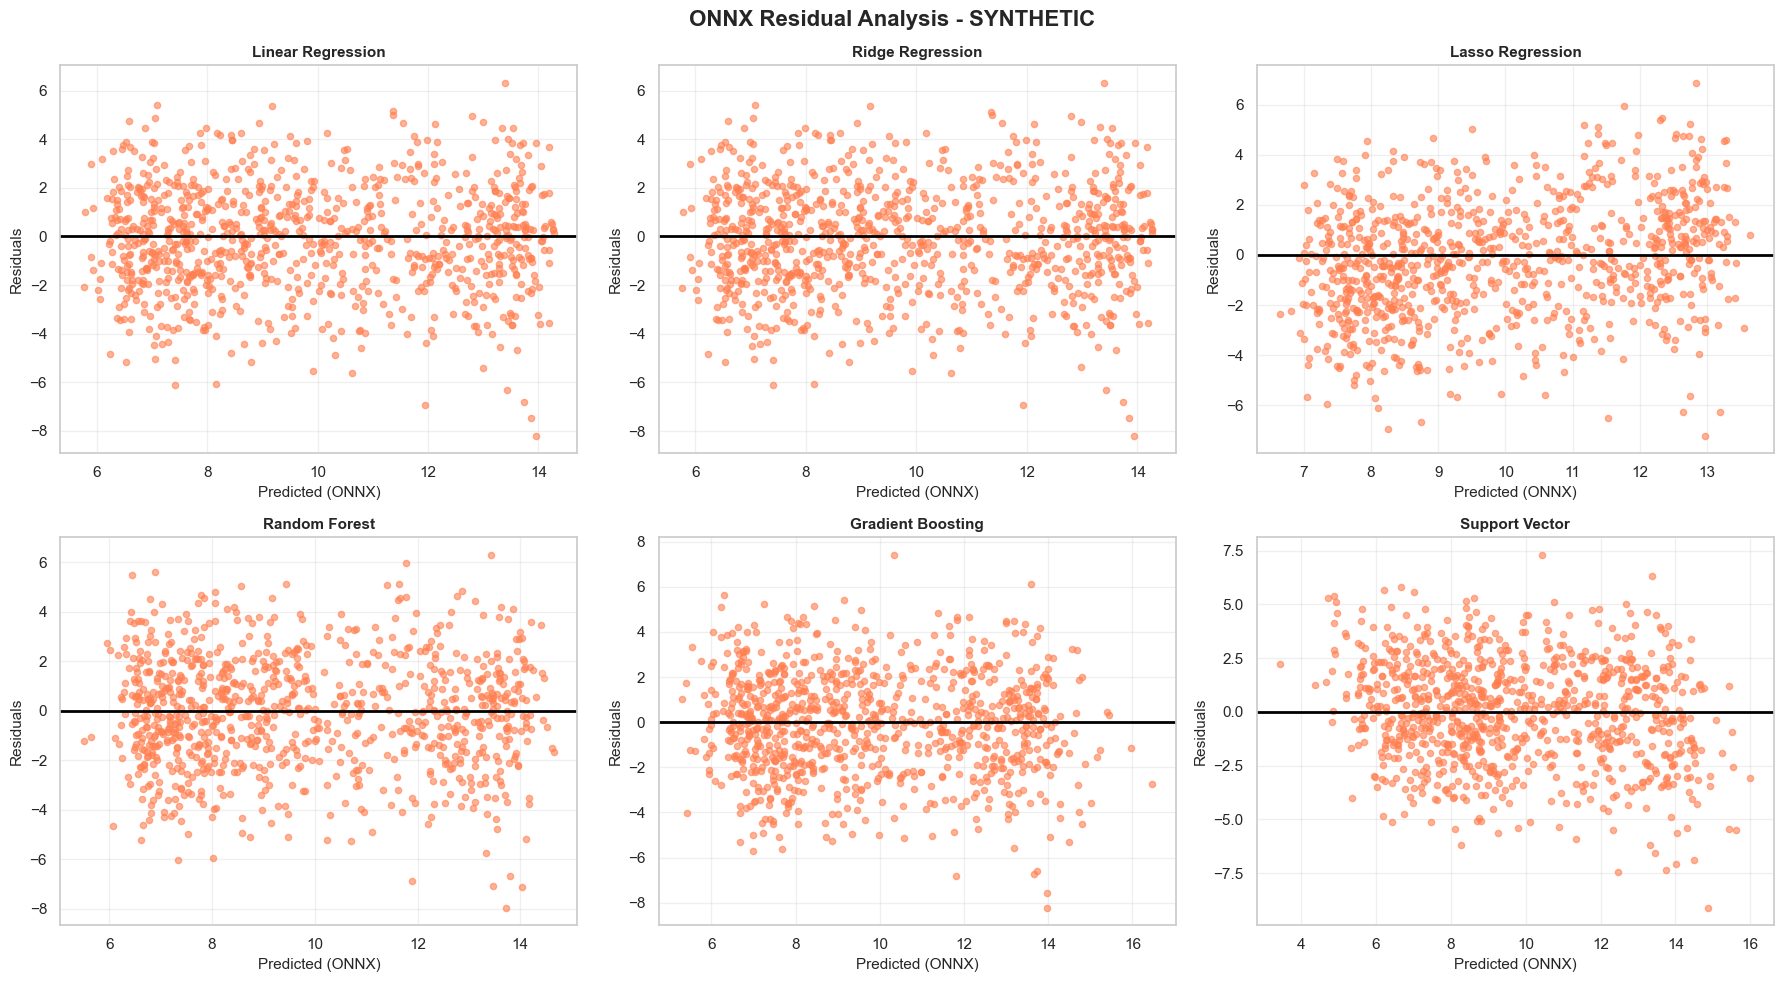

 ONNX residual analysis plots saved


In [50]:

print("SECTION 6.3: VISUALIZATION - RESIDUALS ANALYSIS")
def plot_residuals(results, dataset_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
   
    for i, r in enumerate(results):
        ax = axes[i]
        # USE ONNX PREDICTIONS FOR RESIDUALS
        residuals = r['y_test'] - r['y_pred_onnx']
       
        ax.scatter(r['y_pred_onnx'], residuals, alpha=0.6, s=20, color='coral')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
        ax.set_xlabel('Predicted (ONNX)', fontsize=11)
        ax.set_ylabel('Residuals', fontsize=11)
        ax.set_title(f"{r['model_name']}", fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
   
    plt.suptitle(f'ONNX Residual Analysis - {dataset_name.upper()}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"visualizations/onnx_residuals_analysis_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_residuals(results_real, "real")
if results_synth:
    plot_residuals(results_synth, "synthetic")
print(" ONNX residual analysis plots saved")

### 6-4. Feature Importance

SECTION 6.4: VISUALIZATION - FEATURE IMPORTANCE


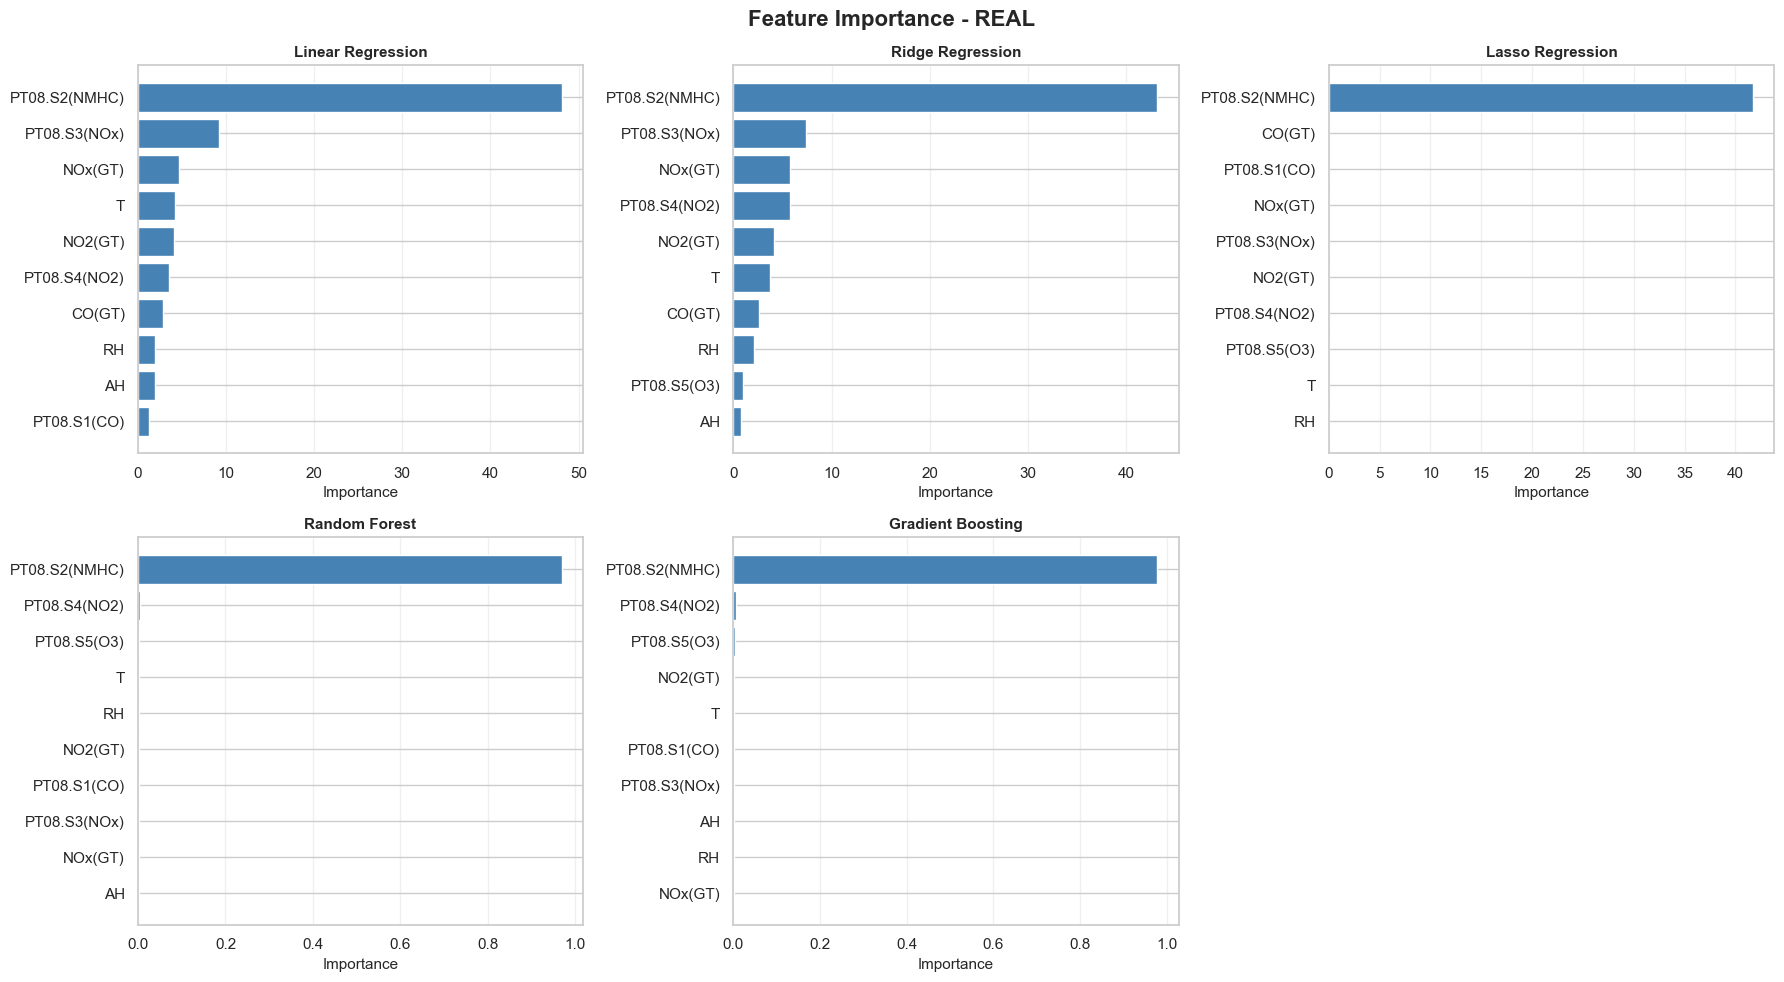

Feature importance plotted and saved for 5 models (real)


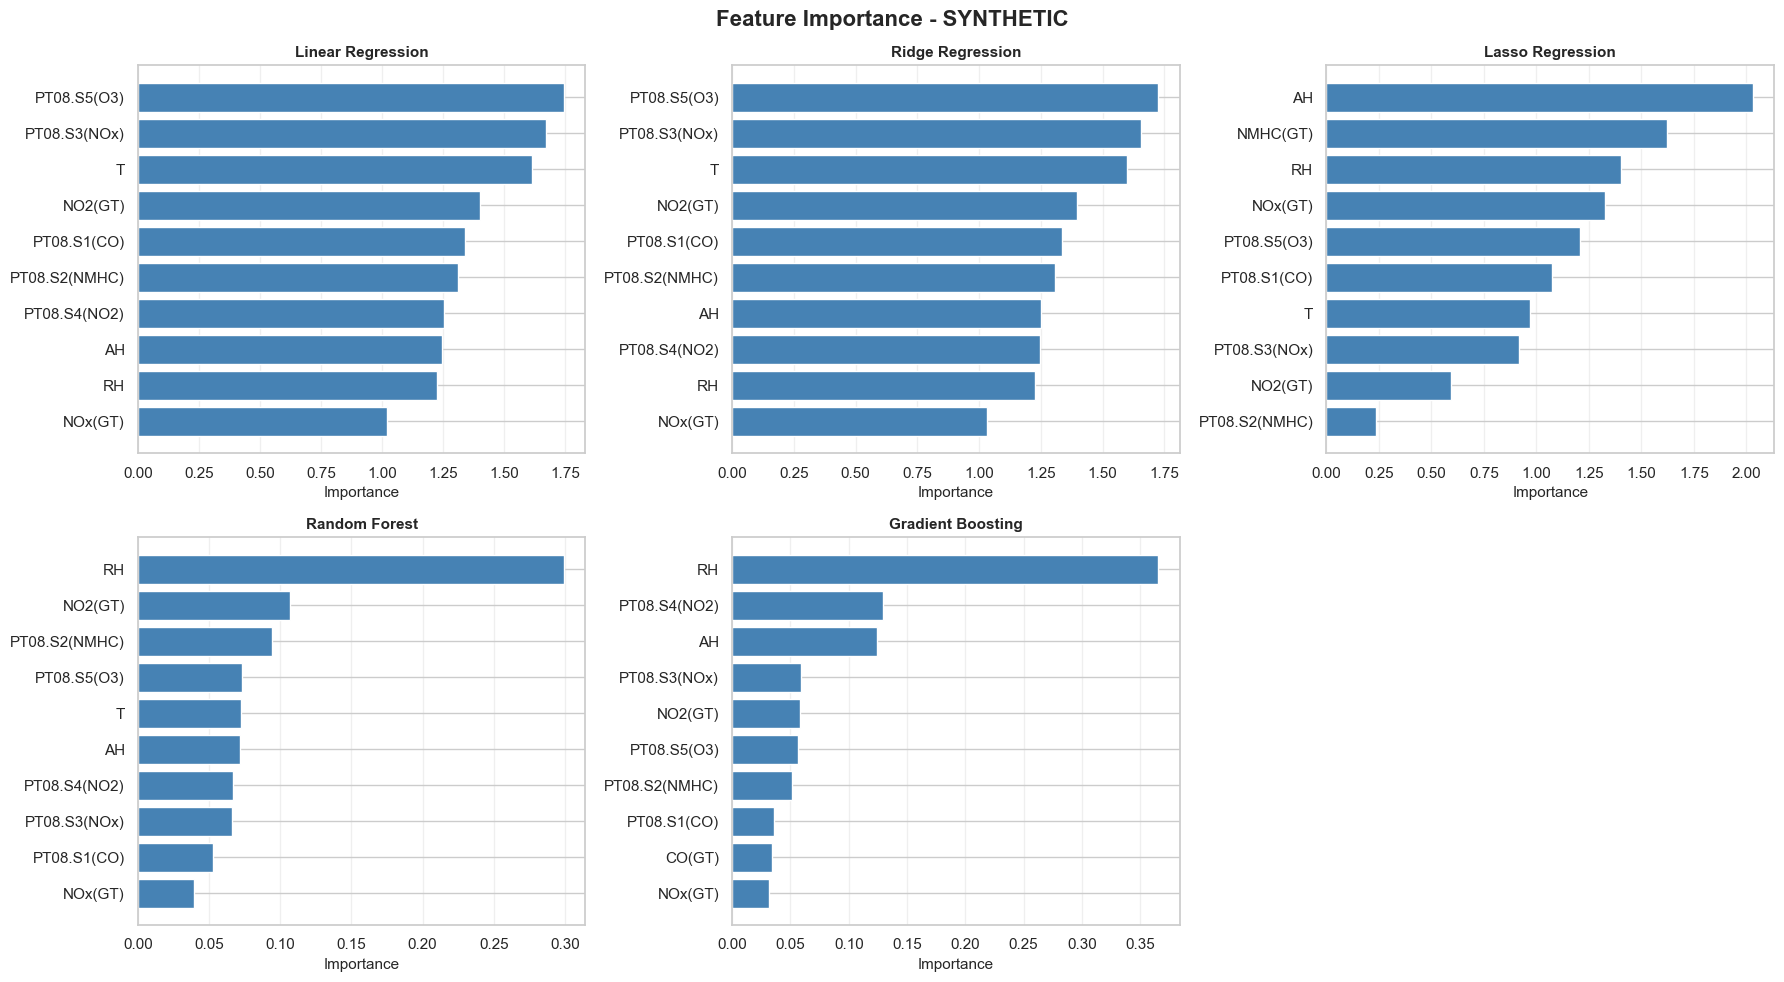

Feature importance plotted and saved for 5 models (synthetic)


In [51]:
print("SECTION 6.4: VISUALIZATION - FEATURE IMPORTANCE")

def plot_feature_importance(results, dataset_name, feature_names):
    models_with_importance = []
    
    for r in results:
        model_name = r['model_name']
        
        # Get corresponding training data
        X_train = X_train_real if dataset_name == "real" else X_train_synth
        
        # Retrain a fresh model
        model_template = models[model_name] 
        model = clone(model_template)
        model.fit(X_train, y_train_real if dataset_name == "real" else y_train_synth)
        
        # Extract importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_)
        else:
            continue 
        
        # Create DataFrame
        imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Attach to result
        enriched_r = r.copy()
        enriched_r['feature_importance'] = imp_df
        models_with_importance.append(enriched_r)
    
    if len(models_with_importance) == 0:
        print(f"No models with feature importance available for {dataset_name}")
        return
    
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, r in enumerate(models_with_importance):
        ax = axes[i]
        top_features = r['feature_importance'].head(10)
        
        ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.invert_yaxis()
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(f"{r['model_name']}", fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f'Feature Importance - {dataset_name.upper()}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"visualizations/feature_importance_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()
    
    # Save to CSV
    os.makedirs("results", exist_ok=True)
    for r in models_with_importance:
        safe_name = r['model_name'].replace(' ', '_').replace('/', '_')
        filename = f"results/feature_importance_{safe_name}_{dataset_name}.csv"
        r['feature_importance'].to_csv(filename, index=False)
    
    print(f"Feature importance plotted and saved for {len(models_with_importance)} models ({dataset_name})")

# Call the function with correct feature names
if results_real:
    plot_feature_importance(results_real, "real", features_real)
if results_synth:
    plot_feature_importance(results_synth, "synthetic", features_synth)

### 6-5. Error Distributaion

SECTION 6.5: VISUALIZATION - ERROR DISTRIBUTION


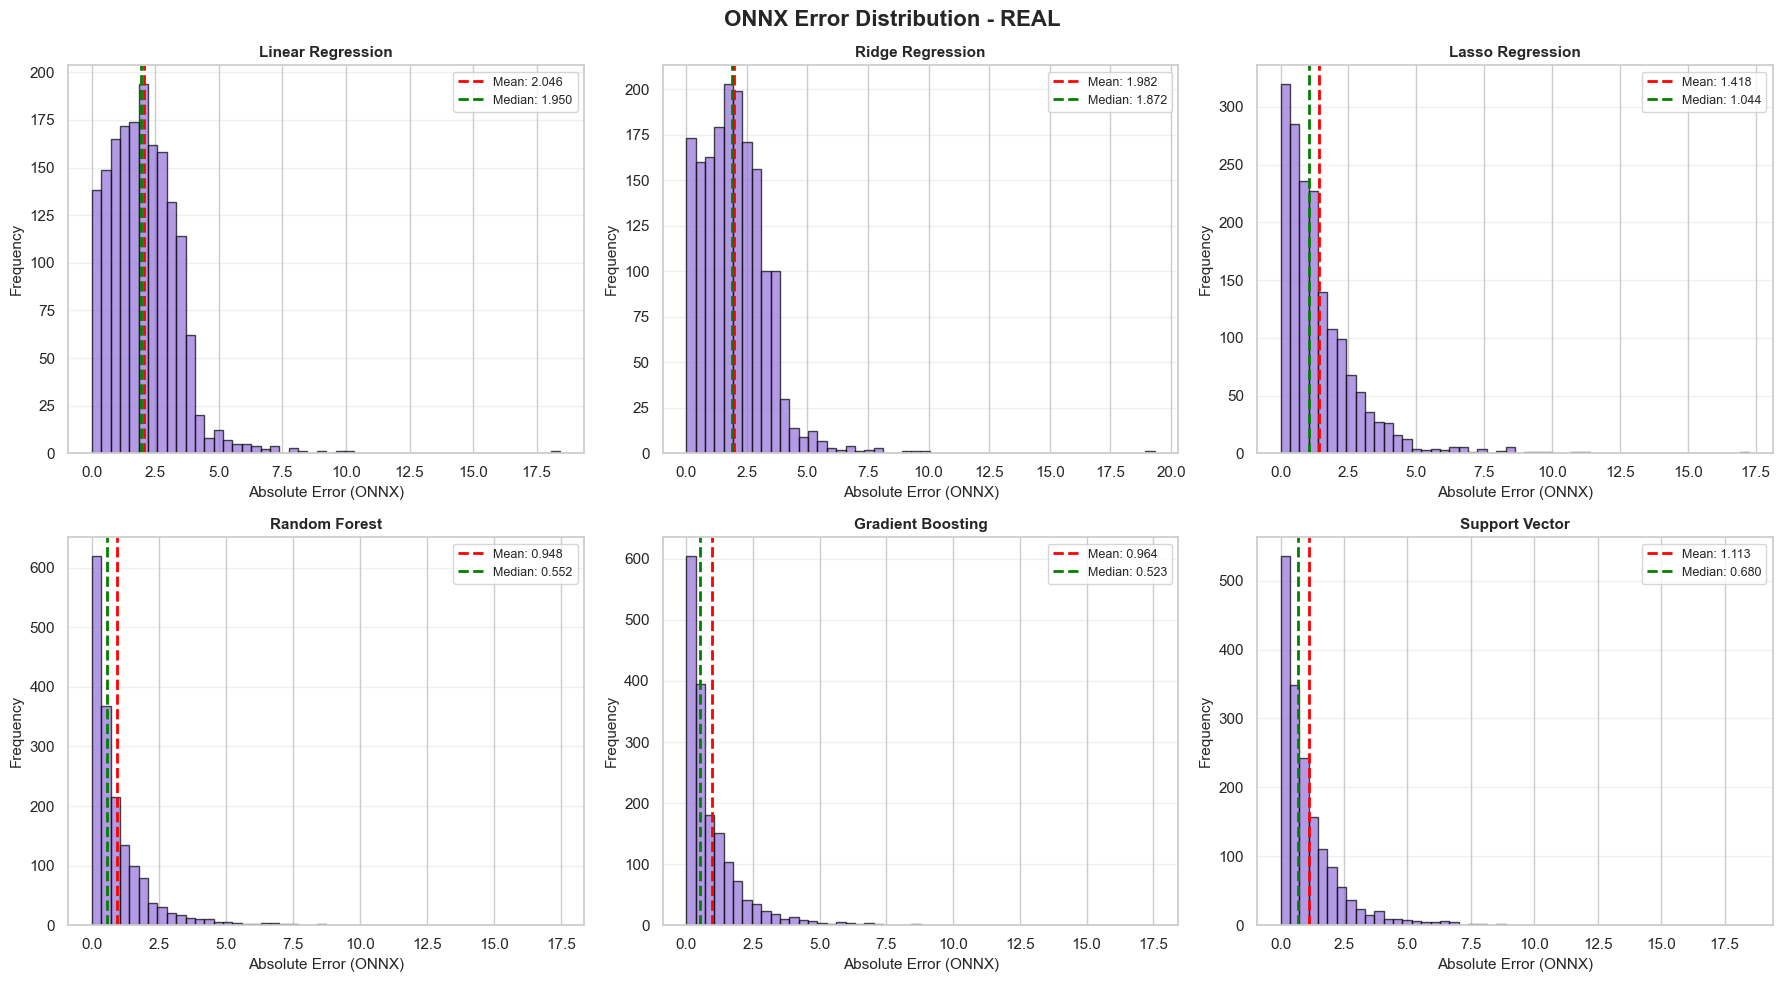

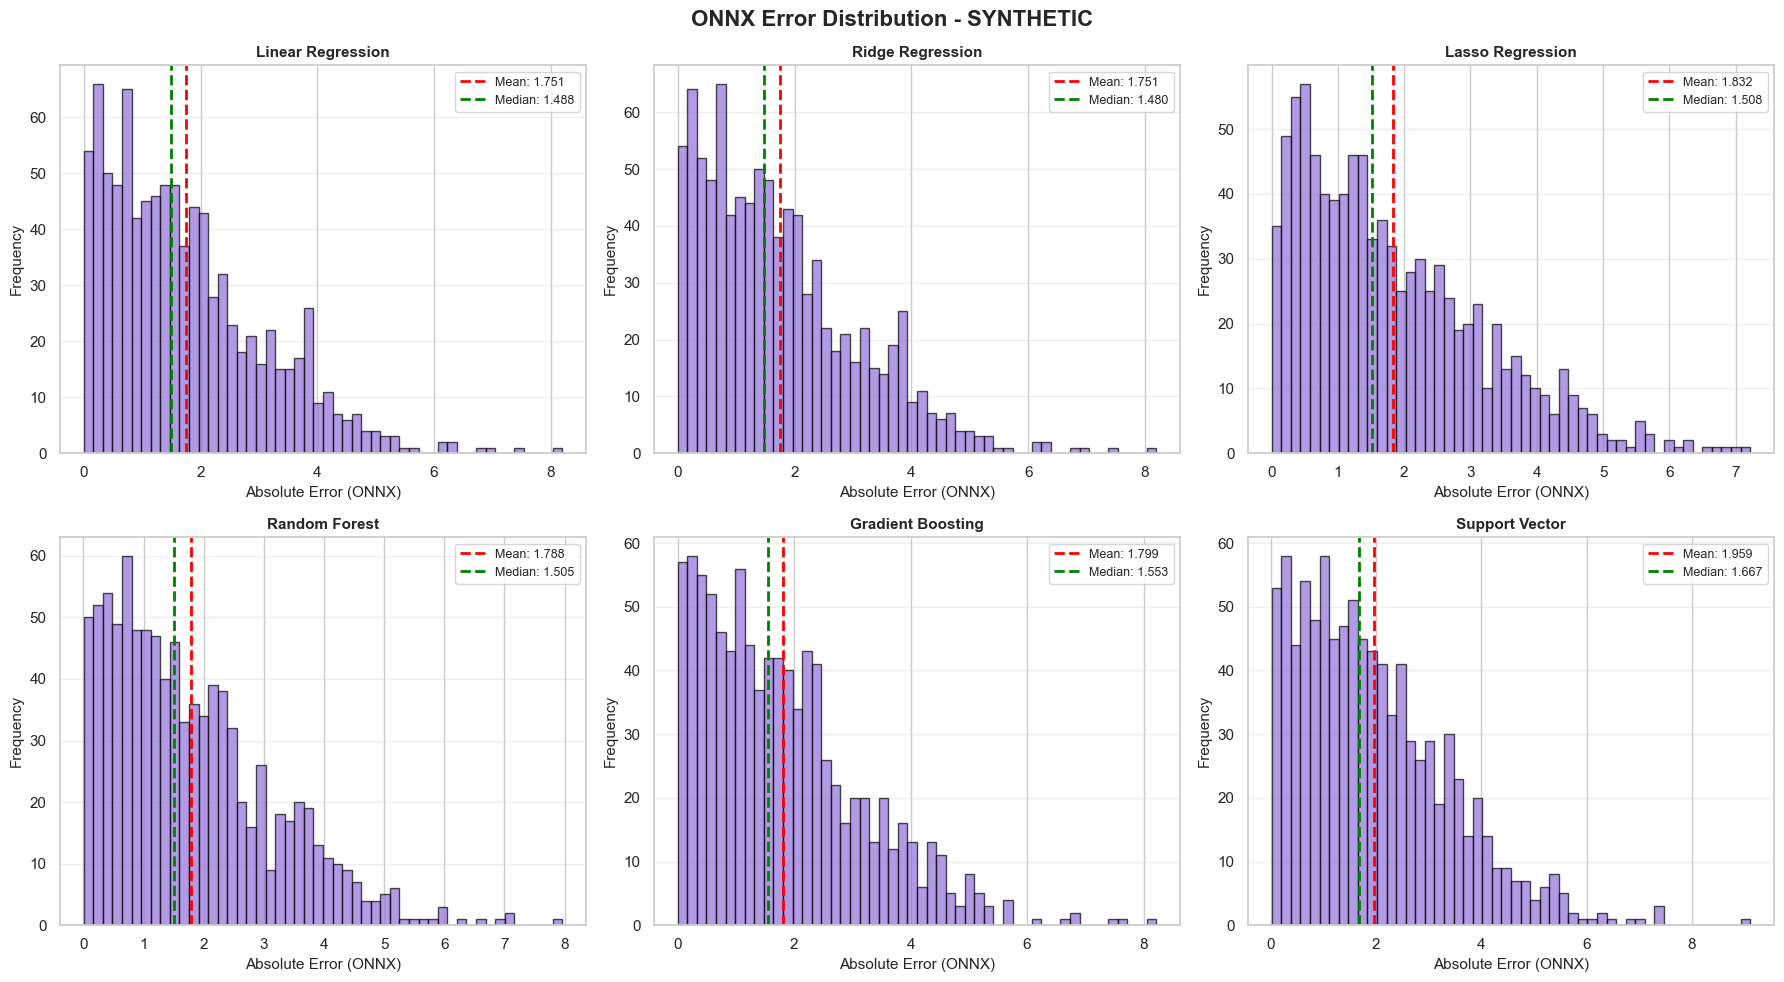

 ONNX error distribution plots saved


In [52]:

print("SECTION 6.5: VISUALIZATION - ERROR DISTRIBUTION")

def plot_error_distribution(results, dataset_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
  
    for i, r in enumerate(results):
        ax = axes[i]
        # use onnx predictions for errors
        errors = np.abs(r['y_test'] - r['y_pred_onnx'])
        mean_error = np.mean(errors)
        median_error = np.median(errors)
      
        ax.hist(errors, bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
        ax.axvline(mean_error, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_error:.3f}')
        ax.axvline(median_error, color='green', linestyle='--', linewidth=2,
                  label=f'Median: {median_error:.3f}')
      
        ax.set_xlabel('Absolute Error (ONNX)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f"{r['model_name']}", fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
  
    plt.suptitle(f'ONNX Error Distribution - {dataset_name.upper()}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"visualizations/onnx_error_distribution_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_error_distribution(results_real, "real")
if results_synth:
    plot_error_distribution(results_synth, "synthetic")
print(" ONNX error distribution plots saved")

### 6-6. Comparison ROC Curves Using ONNX Predictions

SECTION 6.6: COMPARISON ROC CURVES (ONNX PREDICTIONS)


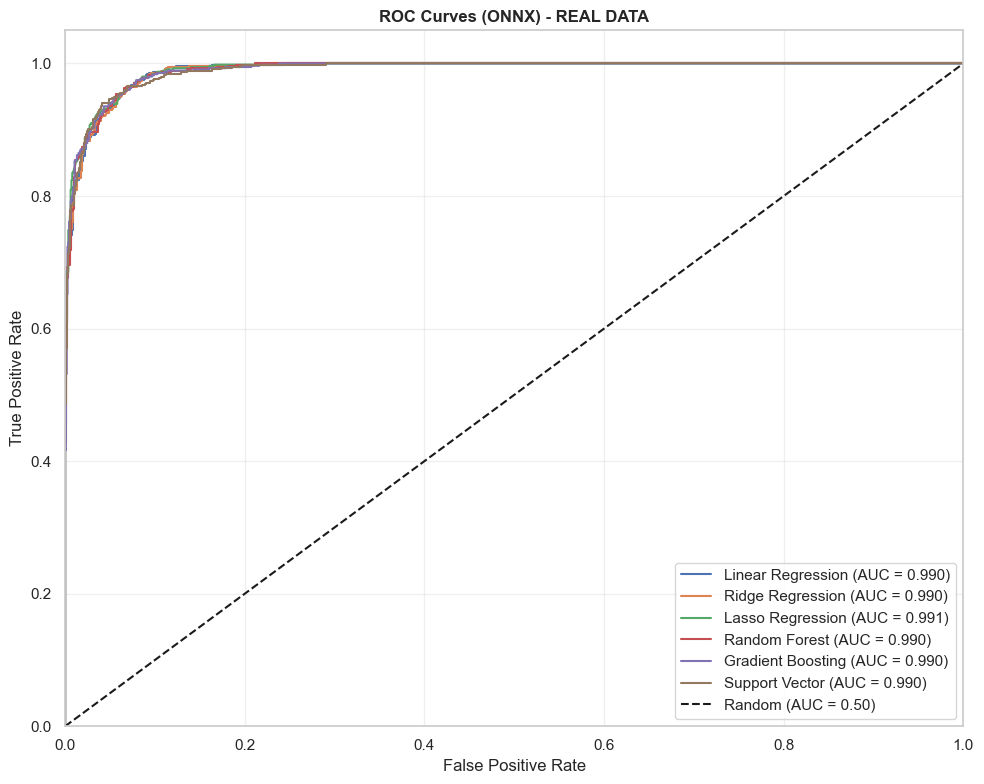

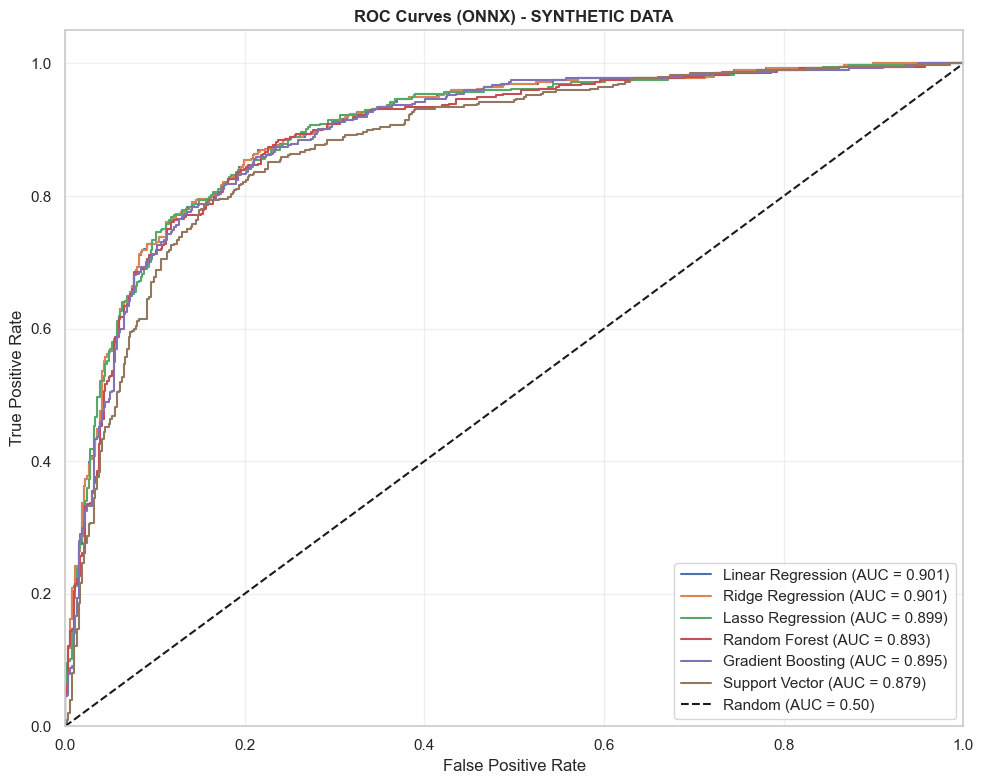

 ONNX ROC comparison plots saved


In [53]:

print("SECTION 6.6: COMPARISON ROC CURVES (ONNX PREDICTIONS)")

def plot_roc_comparison(results, y_test_bin, dataset_name):
    plt.figure(figsize=(10, 8))
    for r in results:
        #use onnx predictions for roc
        fpr, tpr, _ = roc_curve(y_test_bin, r['y_pred_onnx'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{r['model_name']} (AUC = {roc_auc:.3f})")
   
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (ONNX) - {dataset_name.upper()} DATA', fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/onnx_roc_comparison_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_roc_comparison(results_real, y_test_bin_real, "real")
if results_synth:
    plot_roc_comparison(results_synth, y_test_bin_synth, "synthetic")
print(" ONNX ROC comparison plots saved")

### 6-7. Comparison Precision-Recall Curves ONNX Predictions

SECTION 6.8: COMPARISON PRECISION-RECALL CURVES


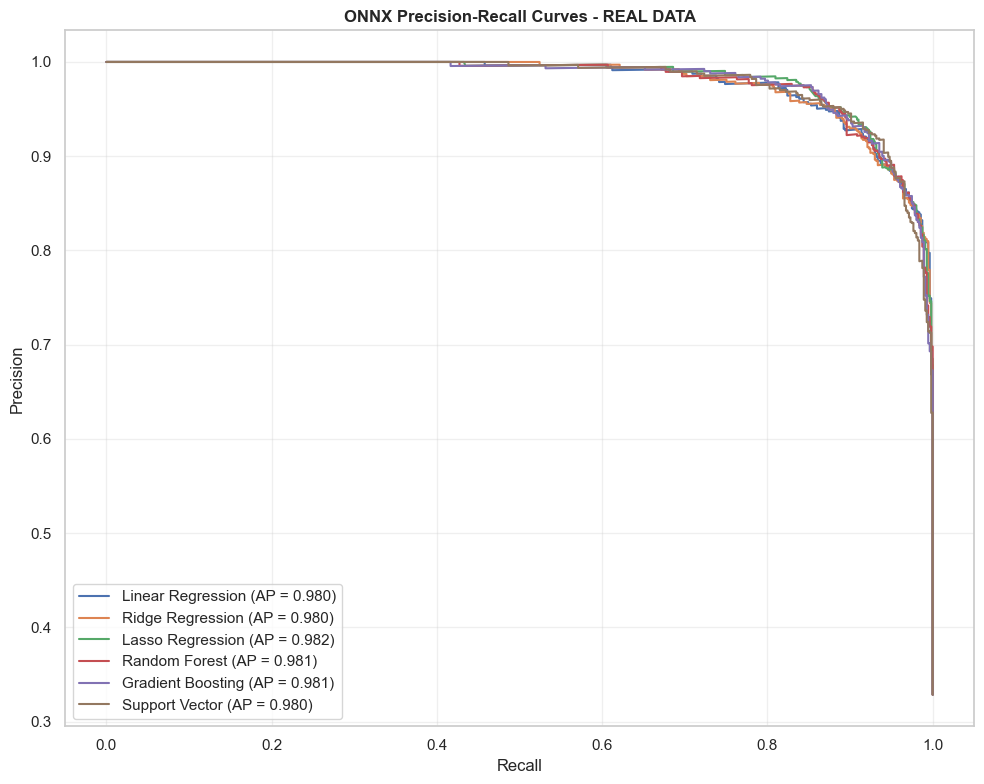

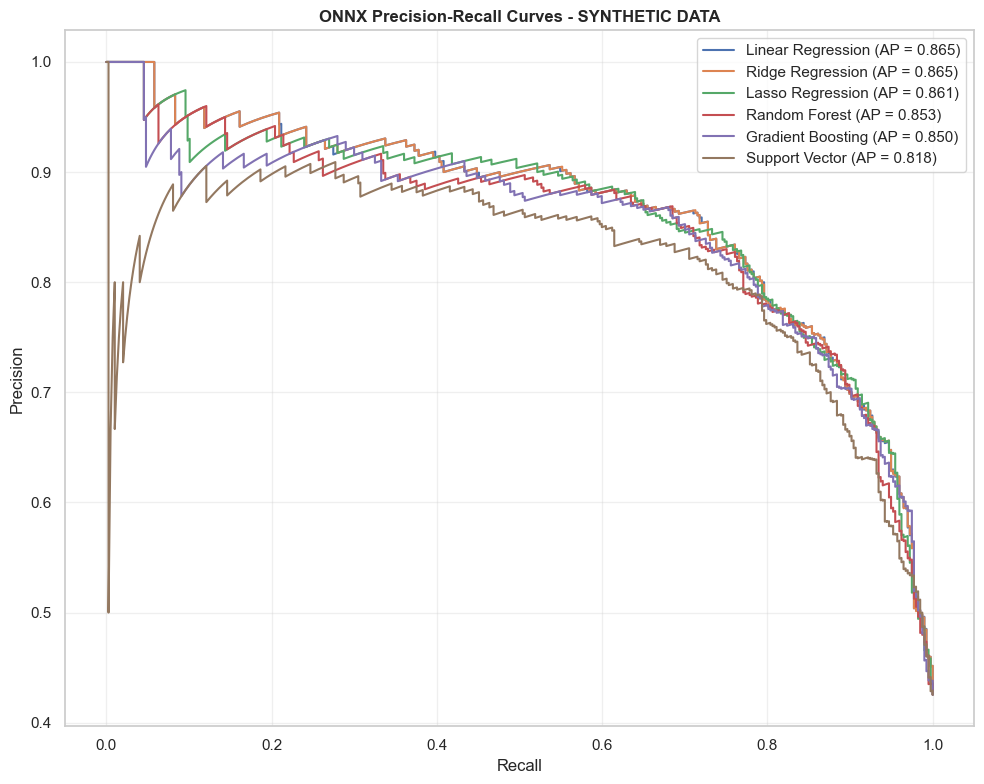

 ONNX Precision-Recall comparison plots saved


In [54]:

print("SECTION 6.8: COMPARISON PRECISION-RECALL CURVES")

def plot_pr_comparison(results, y_test_bin, dataset_name):
    plt.figure(figsize=(10, 8))
    for r in results:
        #use onnx predictions for PR curve
        precision, recall, _ = precision_recall_curve(y_test_bin, r['y_pred_onnx'])
        ap = average_precision_score(y_test_bin, r['y_pred_onnx'])
        plt.plot(recall, precision, label=f"{r['model_name']} (AP = {ap:.3f})")
   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'ONNX Precision-Recall Curves - {dataset_name.upper()} DATA', fontweight='bold')
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/onnx_pr_comparison_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_pr_comparison(results_real, y_test_bin_real, "real")
if results_synth:
    plot_pr_comparison(results_synth, y_test_bin_synth, "synthetic")
print(" ONNX Precision-Recall comparison plots saved")

### 6-8. Overfitting

SECTION 6.8: OVERFITTING COMPARISON VISUALIZATION


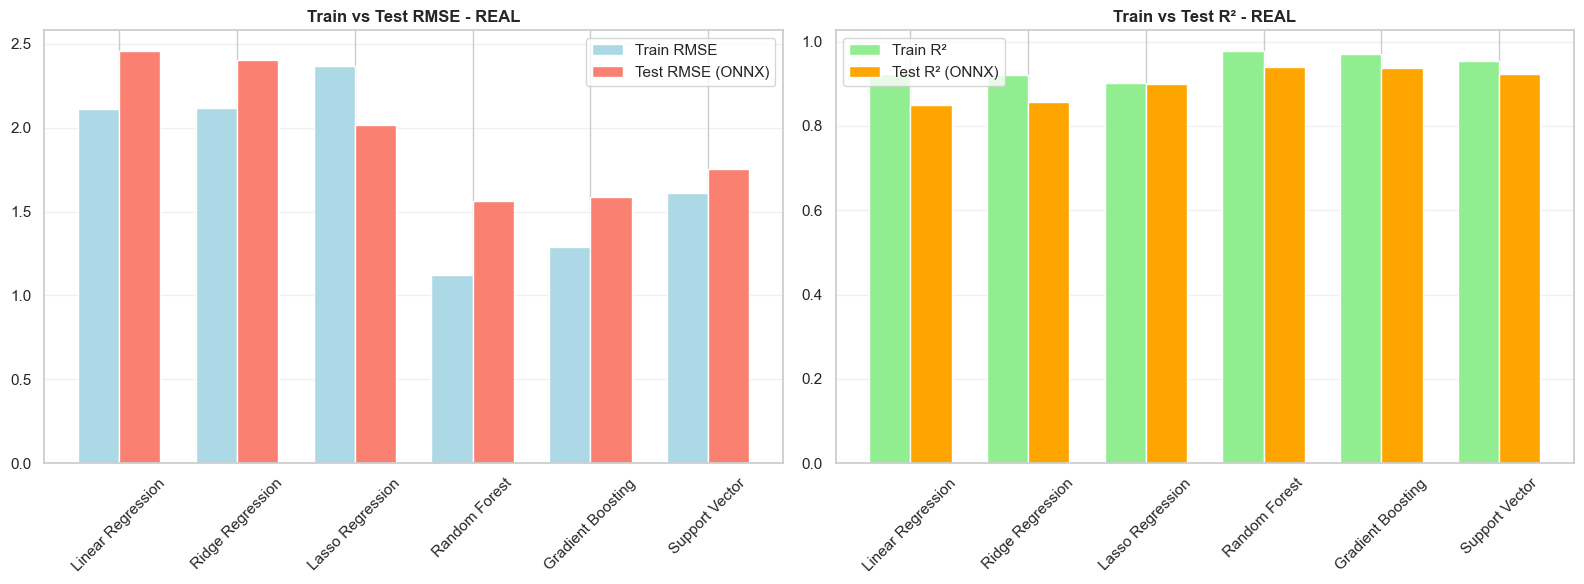

Overfitting comparison plot generated for real


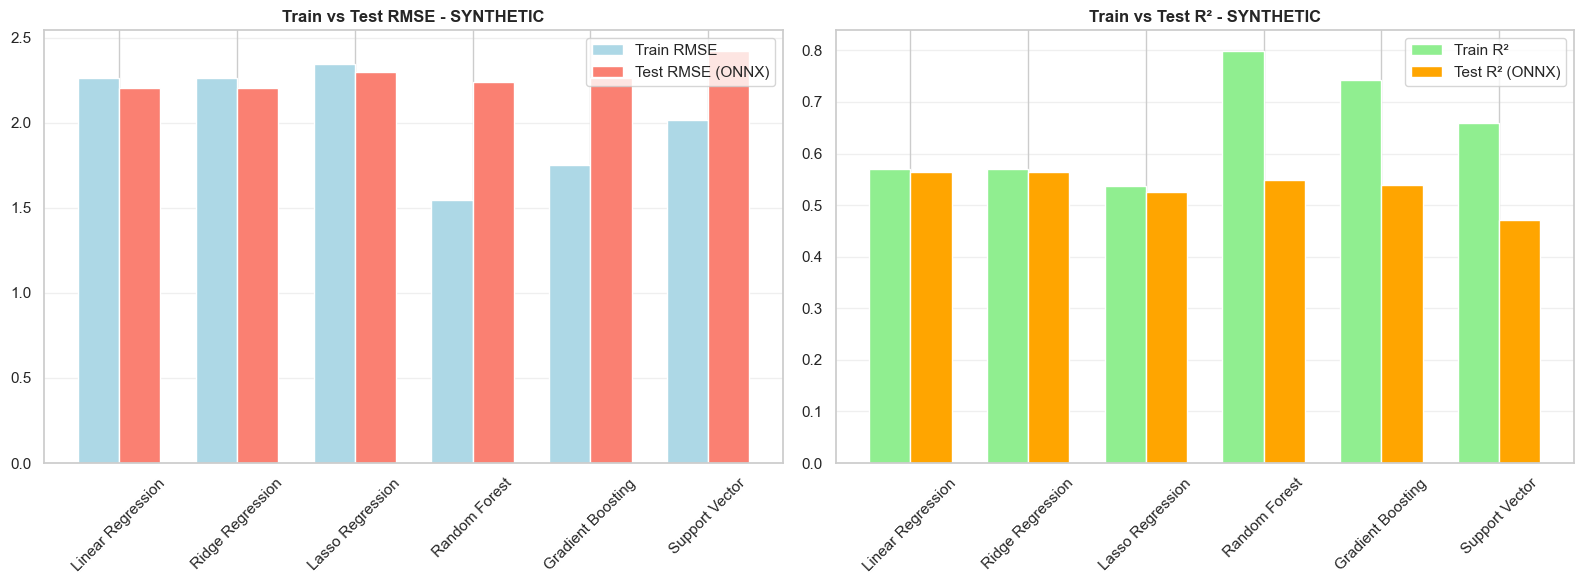

Overfitting comparison plot generated for synthetic
 Overfitting comparison plots saved and displayed


In [55]:
print("SECTION 6.8: OVERFITTING COMPARISON VISUALIZATION")

def plot_overfitting_comparison(results, dataset_name):
    if not results:
        print(f"No results for {dataset_name} — skipping overfitting plot")
        return
    
    models_list = [r['model_name'] for r in results]
    x = np.arange(len(models_list))
    width = 0.35
    
    # Lists to store values
    train_rmse_list = []
    test_rmse_list = []
    train_r2_list = []
    test_r2_list = []
    
    # Select correct training data
    X_train = X_train_real if dataset_name == "real" else X_train_synth
    y_train = y_train_real if dataset_name == "real" else y_train_synth
    
    for r in results:
        model_name = r['model_name']
        
        # Retrain fresh sklearn model to get training metrics
        model_template = models[model_name]  # from global models dict
        model = clone(model_template)
        model.fit(X_train, y_train)
        
        # Training predictions and metrics
        y_train_pred = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        
        # Test metrics (from ONNX — already in results)
        test_rmse = r['test_rmse']
        test_r2 = r['test_r2']
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        test_r2_list.append(test_r2)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # RMSE Plot
    axes[0].bar(x - width/2, train_rmse_list, width, label='Train RMSE', color='lightblue')
    axes[0].bar(x + width/2, test_rmse_list, width, label='Test RMSE (ONNX)', color='salmon')
    axes[0].set_title(f'Train vs Test RMSE - {dataset_name.upper()}', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models_list, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # R² Plot
    axes[1].bar(x - width/2, train_r2_list, width, label='Train R²', color='lightgreen')
    axes[1].bar(x + width/2, test_r2_list, width, label='Test R² (ONNX)', color='orange')
    axes[1].set_title(f'Train vs Test R² - {dataset_name.upper()}', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models_list, rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"visualizations/overfitting_comparison_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()
    
    print(f"Overfitting comparison plot generated for {dataset_name}")

# Call the function
if results_real:
    plot_overfitting_comparison(results_real, "real")
if results_synth:
    plot_overfitting_comparison(results_synth, "synthetic")

print(" Overfitting comparison plots saved and displayed")

### 6-9. Cross-Valiation Score Distributaion

SECTION 6.9: CROSS-VALIDATION SCORE DISTRIBUTION


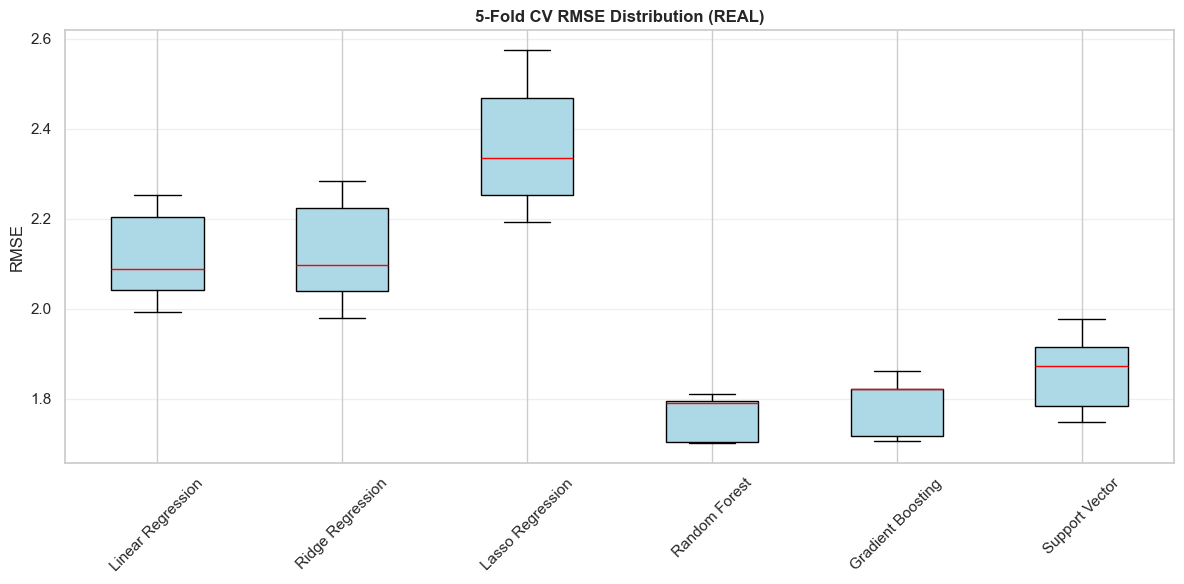

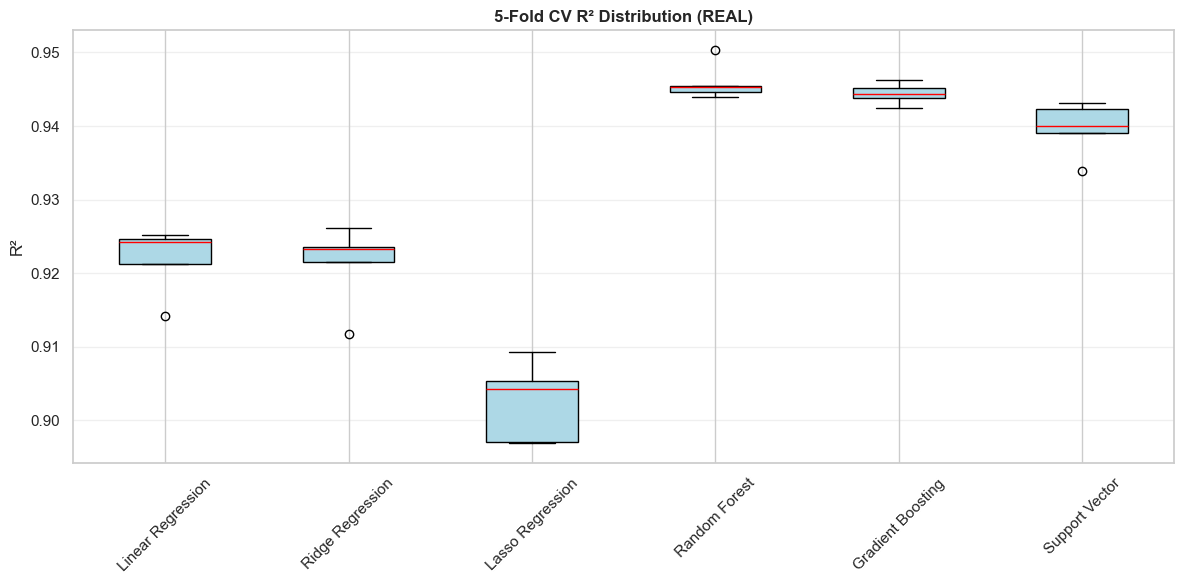

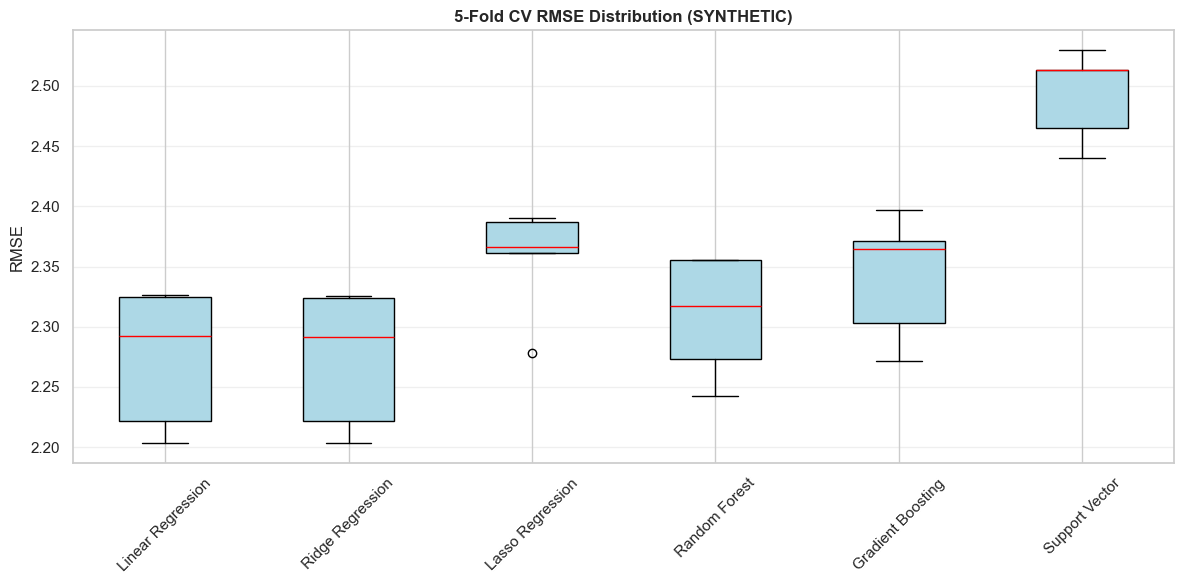

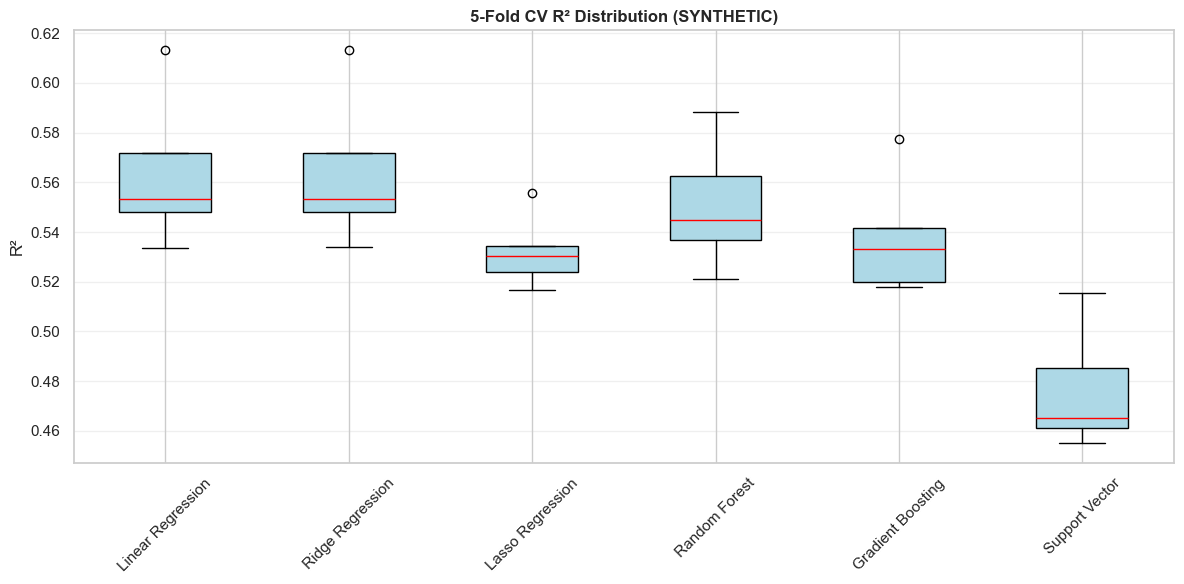

CV distribution plots saved


In [56]:

print("SECTION 6.9: CROSS-VALIDATION SCORE DISTRIBUTION")
def plot_cv_scores(results, dataset_name, metric='RMSE'):
    models_list = [r['model_name'] for r in results]
    if metric == 'RMSE':
        data = [r['cv_rmse_scores'] for r in results]
        title = f'5-Fold CV RMSE Distribution ({dataset_name.upper()})'
        ylabel = 'RMSE'
    else:
        data = [r['cv_r2_scores'] for r in results]
        title = f'5-Fold CV R² Distribution ({dataset_name.upper()})'
        ylabel = 'R²'
   
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.boxplot(data, labels=models_list, patch_artist=True,
               boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/cv_{metric.lower()}_distribution_{dataset_name}.png", dpi=300)
    plt.show()
    plt.close()

if results_real:
    plot_cv_scores(results_real, "real", 'RMSE')
    plot_cv_scores(results_real, "real", 'R2')
if results_synth:
    plot_cv_scores(results_synth, "synthetic", 'RMSE')
    plot_cv_scores(results_synth, "synthetic", 'R2')
print("CV distribution plots saved")

# FINAL SUMMARY

In [57]:

print("FINAL SUMMARY")
def find_best_models(results, dataset_name):
    if not results:
        print(f"No successful ONNX models for {dataset_name}")
        return
    
    best_r2 = max(results, key=lambda x: x['test_r2'])
    best_rmse = min(results, key=lambda x: x['test_rmse'])
   
    print(f"\n{dataset_name.upper()} - BEST ONNX PERFORMERS:")
    print(f" Best R²: {best_r2['model_name']} (R²={best_r2['test_r2']:.4f})")
    print(f" Best RMSE: {best_rmse['model_name']} (RMSE={best_rmse['test_rmse']:.4f})")

if results_real:
    find_best_models(results_real, "real")
if results_synth:
    find_best_models(results_synth, "synthetic")

# Count successful ONNX exports
num_onnx_real = len([r for r in results_real if r['onnx_file'] is not None])
num_onnx_synth = len([r for r in results_synth if r['onnx_file'] is not None])

print("\n")
print(f"\n Trained: {len(results_real) + len(results_synth)} models")
print(f" ONNX models exported & loaded: {num_onnx_real + num_onnx_synth}")
print(f" ONNX predictions generated: {len(results_real) + len(results_synth)} test sets")

FINAL SUMMARY

REAL - BEST ONNX PERFORMERS:
 Best R²: Random Forest (R²=0.9397)
 Best RMSE: Random Forest (RMSE=1.5615)

SYNTHETIC - BEST ONNX PERFORMERS:
 Best R²: Ridge Regression (R²=0.5634)
 Best RMSE: Ridge Regression (RMSE=2.2018)



 Trained: 12 models
 ONNX models exported & loaded: 12
 ONNX predictions generated: 12 test sets
